In [1]:

"""
Created on Sun Nov 12 18:26:15 2017

@author: rahul
Topic ; Apparel Recommendation system
"""
#importing all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

#loading the data using pandas' read_json file.

data = pd.read_json('tops_fashion.json')

print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])
data.columns

#but for our case we need only 7 features

'''
Of these 19 features, we will be using only 6 features in this workshop.
1. asin  ( Amazon standard identification number)
2. brand ( brand to which the product belongs to )
3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
5. medium_image_url  ( url of the image )
6. title (title of the product.)
7. formatted_price (price of the product)
'''
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]
 #now data with 7 features
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1]) 

data.head()


('Number of data points : ', 183138, 'Number of features/variables:', 19)
('Number of data points : ', 183138, 'Number of features:', 7)


asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

In [2]:
#Basic stats for the feature: product_type_name
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [3]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[(u'SHIRT', 167794),
 (u'APPAREL', 3549),
 (u'BOOKS_1973_AND_LATER', 3336),
 (u'DRESS', 1584),
 (u'SPORTING_GOODS', 1281),
 (u'SWEATER', 837),
 (u'OUTERWEAR', 796),
 (u'OUTDOOR_RECREATION_PRODUCT', 729),
 (u'ACCESSORY', 636),
 (u'UNDERWEAR', 425)]

In [4]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [5]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[(u'Zago', 223),
 (u'XQS', 222),
 (u'Yayun', 215),
 (u'YUNY', 198),
 (u'XiaoTianXin-women clothes', 193),
 (u'Generic', 192),
 (u'Boohoo', 190),
 (u'Alion', 188),
 (u'TheMogan', 187),
 (u'Abetteric', 187)]

In [6]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [7]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 (u'Black', 13207),
 (u'White', 8616),
 (u'Blue', 3570),
 (u'Red', 2289),
 (u'Pink', 1842),
 (u'Grey', 1499),
 (u'*', 1388),
 (u'Green', 1258),
 (u'Multi', 1203)]

In [8]:
 
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [9]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 (u'$19.99', 945),
 (u'$9.99', 749),
 (u'$9.50', 601),
 (u'$14.99', 472),
 (u'$7.50', 463),
 (u'$24.99', 414),
 (u'$29.99', 370),
 (u'$8.99', 343),
 (u'$9.01', 336)]

In [10]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [11]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

('Number of data points After eliminating price=NULL :', 28395)


In [12]:
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

('Number of data points After eliminating color=NULL :', 28385)


In [13]:
# read data from pickle file from previous stage
#data = pd.read_pickle('pickels/28k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
# we have 2325 products which have same title but different color


2325


In [14]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

('After removal of products with short description:', 27949)


In [15]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [16]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [17]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.izip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [18]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [19]:
print('Number of data points : ', data.shape[0])

('Number of data points : ', 17593)


In [20]:
data.to_pickle('pickels/17k_apperal_data')

In [ ]:
start_time = time.clock()
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.izip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)
print(time.clock() - start_time, "seconds")

In [21]:
data = pd.read_pickle('pickels/16k_py2')


In [22]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
6   Women's Unique 100% Cotton T - Special Olympic...           $9.99  
15  FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
27  Supernatural Chibis Sam Dean And Castiel O Nec...           $7.39  
46  Fifth Degree Womens Gold Foil Graphic Tees Jun...           $6.95

In [23]:
data.describe()

asin      brand  color  \
count        16042      15997  16042   
unique       16042       3543   3613   
top     B0756L6MTG  Anna-Kaci  Black   
freq             1        117   2885   

                                         medium_image_url product_type_name  \
count                                               16042             16042   
unique                                              15185                55   
top     https://images-na.ssl-images-amazon.com/images...             SHIRT   
freq                                                   11             12827   

                                            title formatted_price  
count                                       16042           16042  
unique                                      16042            2788  
top     The North Face Women`s Micro Logo S/S Tee          $19.99  
freq                                            1             474

In [24]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

('list of stop words:', set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u'where', u'few', u'because', u'doing', u'some', u'hasn', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'while', u're', u'does', u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u'were', u'here', u'shouldn', u'hers', u'by', u'on', u'about', u'couldn', u'of', u'against', u's', u'isn', u'or', u'own', u'into', u'yourself', u'down', u'mightn', u'wasn', u'your', u'from', u'her', u'their', u'aren', u'there', u'been', u'whom', u'too', u'wouldn', u'themselves', u'weren', u'was', u'until', u'more', u'himself', u'that', u'but', u'don', u'with', u'than', u'those', u'he', u'me', u'myself', u'ma', u'these', u'up', 

In [25]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

(6.619636, 'seconds')


In [26]:
data.to_pickle('pickels/16k_apperal_data_preprocessed_py2')

In [27]:
data=pd.read_pickle('pickels/16k_apperal_data_preprocessed_py2')

In [28]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus

# What is a sparse vector?

# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc


(16042, 12609)

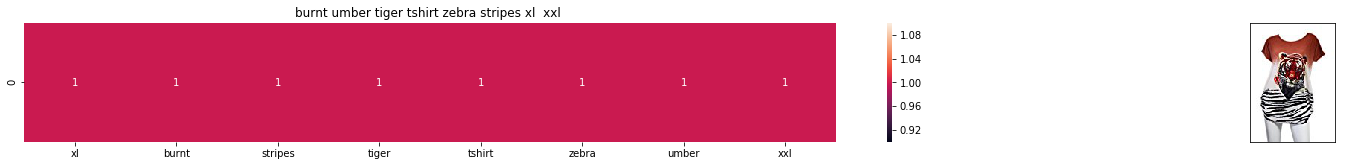

('ASIN :', u'B00JXQB5FQ')
('Brand:', u'Si Row')
('Title:', u'burnt umber tiger tshirt zebra stripes xl  xxl ')
('Euclidean similarity with the query image :', 0.0)


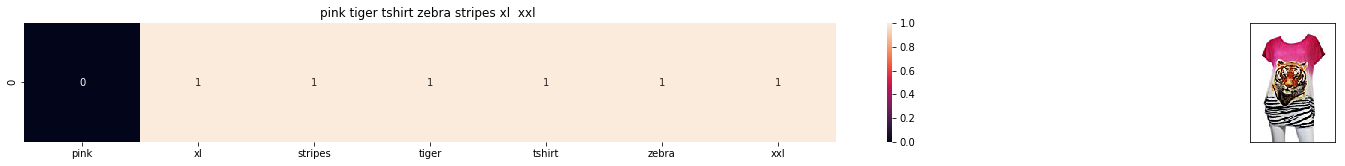

('ASIN :', u'B00JXQASS6')
('Brand:', u'Si Row')
('Title:', u'pink tiger tshirt zebra stripes xl  xxl ')
('Euclidean similarity with the query image :', 1.7320508075688772)


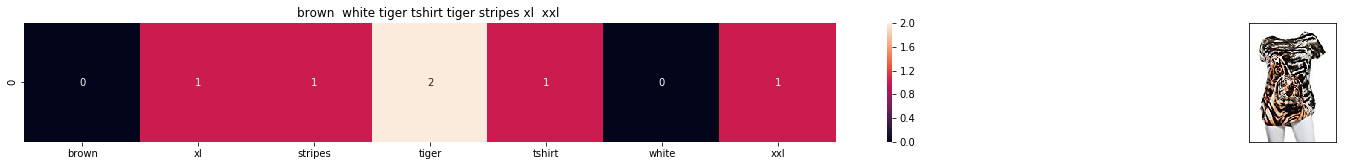

('ASIN :', u'B00JXQCWTO')
('Brand:', u'Si Row')
('Title:', u'brown  white tiger tshirt tiger stripes xl  xxl ')
('Euclidean similarity with the query image :', 2.4494897427831779)


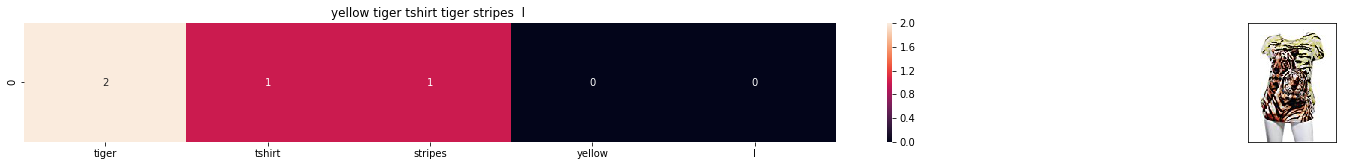

('ASIN :', u'B00JXQCUIC')
('Brand:', u'Si Row')
('Title:', u'yellow tiger tshirt tiger stripes  l ')
('Euclidean similarity with the query image :', 2.6457513110645907)


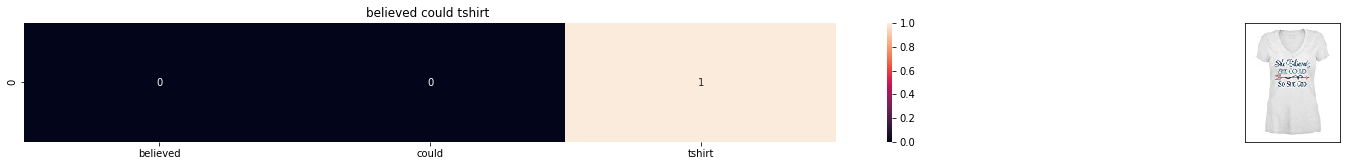

('ASIN :', u'B07568NZX4')
('Brand:', u'Rustic Grace')
('Title:', u'believed could tshirt ')
('Euclidean similarity with the query image :', 3.0)


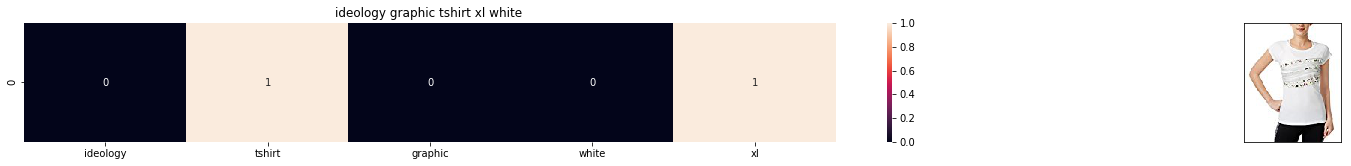

('ASIN :', u'B01NB0NKRO')
('Brand:', u'Ideology')
('Title:', u'ideology graphic tshirt xl white ')
('Euclidean similarity with the query image :', 3.0)


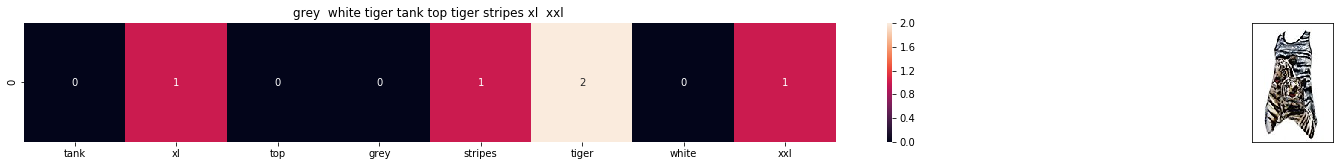

('ASIN :', u'B00JXQAFZ2')
('Brand:', u'Si Row')
('Title:', u'grey  white tiger tank top tiger stripes xl  xxl ')
('Euclidean similarity with the query image :', 3.0)


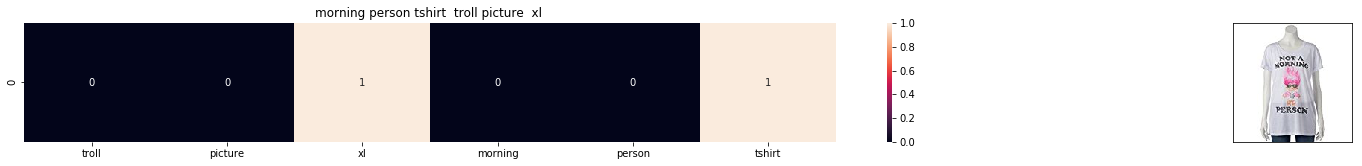

('ASIN :', u'B01CLS8LMW')
('Brand:', u'Awake')
('Title:', u'morning person tshirt  troll picture  xl ')
('Euclidean similarity with the query image :', 3.1622776601683795)


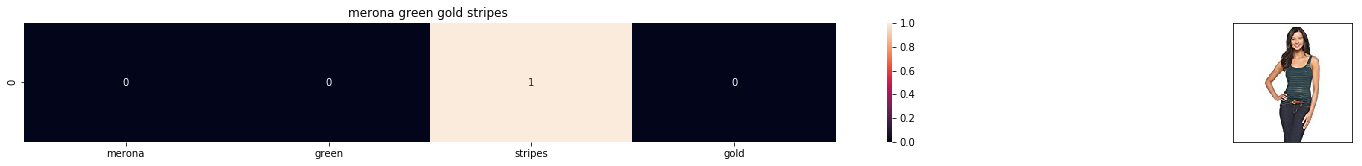

('ASIN :', u'B01KVZUB6G')
('Brand:', u'Merona')
('Title:', u'merona green gold stripes ')
('Euclidean similarity with the query image :', 3.1622776601683795)


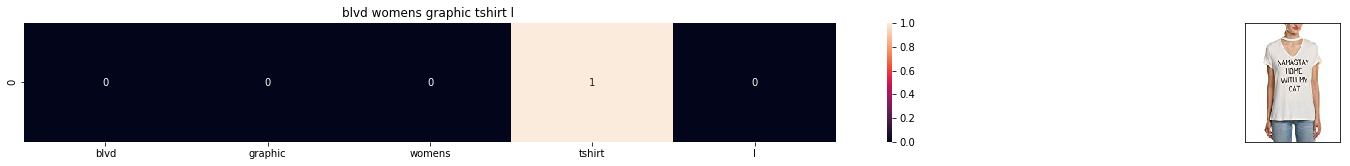

('ASIN :', u'B0733R2CJK')
('Brand:', u'BLVD')
('Title:', u'blvd womens graphic tshirt l ')
('Euclidean similarity with the query image :', 3.1622776601683795)


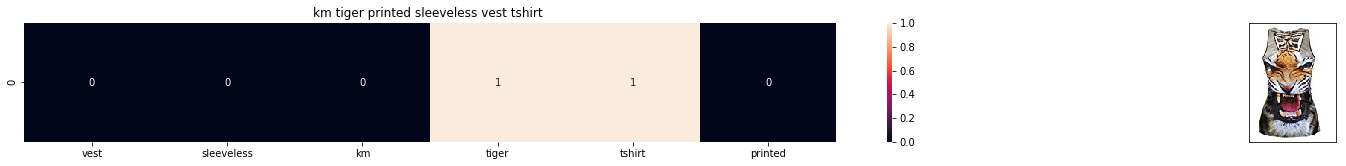

('ASIN :', u'B012VQLT6Y')
('Brand:', u'KM T-shirt')
('Title:', u'km tiger printed sleeveless vest tshirt ')
('Euclidean similarity with the query image :', 3.1622776601683795)


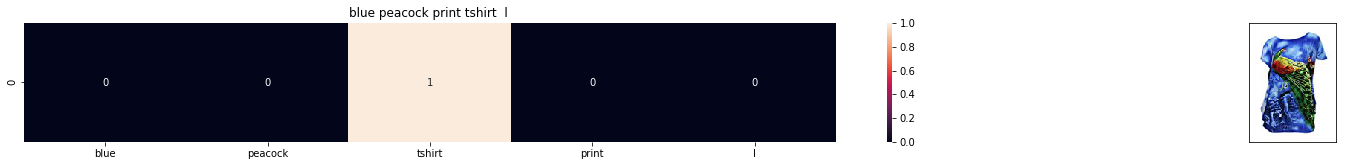

('ASIN :', u'B00JXQC8L6')
('Brand:', u'Si Row')
('Title:', u'blue peacock print tshirt  l ')
('Euclidean similarity with the query image :', 3.1622776601683795)


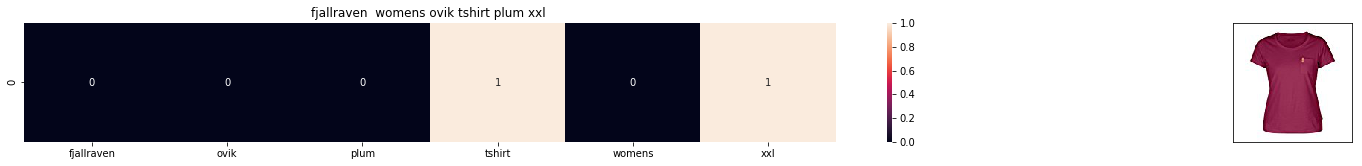

('ASIN :', u'B06XC3CZF6')
('Brand:', u'Fjallraven')
('Title:', u'fjallraven  womens ovik tshirt plum xxl ')
('Euclidean similarity with the query image :', 3.1622776601683795)


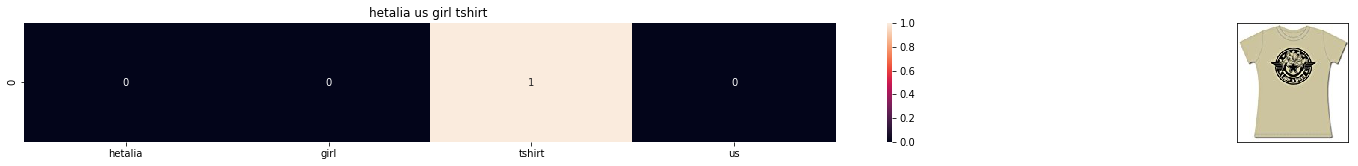

('ASIN :', u'B005IT8OBA')
('Brand:', u'Hetalia')
('Title:', u'hetalia us girl tshirt ')
('Euclidean similarity with the query image :', 3.1622776601683795)


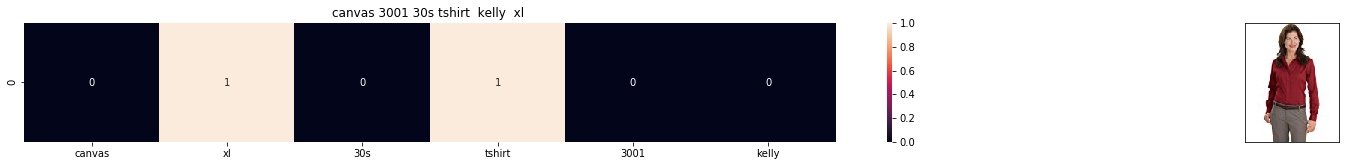

('ASIN :', u'B0088PN0LA')
('Brand:', u'Red House')
('Title:', u'canvas 3001 30s tshirt  kelly  xl ')
('Euclidean similarity with the query image :', 3.1622776601683795)


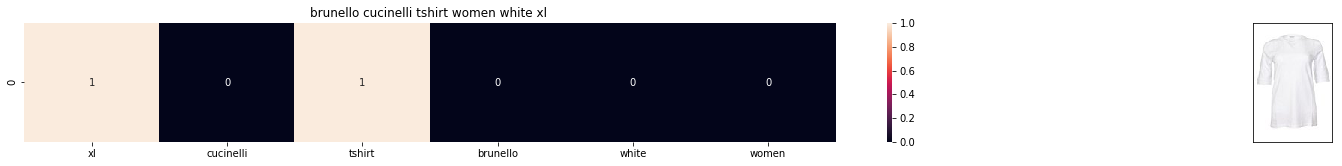

('ASIN :', u'B06X99V6WC')
('Brand:', u'Brunello Cucinelli')
('Title:', u'brunello cucinelli tshirt women white xl ')
('Euclidean similarity with the query image :', 3.1622776601683795)


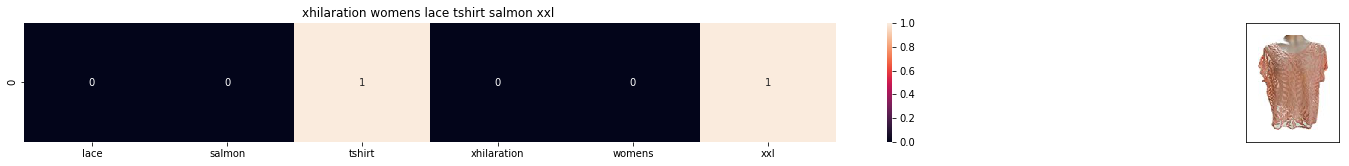

('ASIN :', u'B06Y1JPW1Q')
('Brand:', u'Xhilaration')
('Title:', u'xhilaration womens lace tshirt salmon xxl ')
('Euclidean similarity with the query image :', 3.1622776601683795)


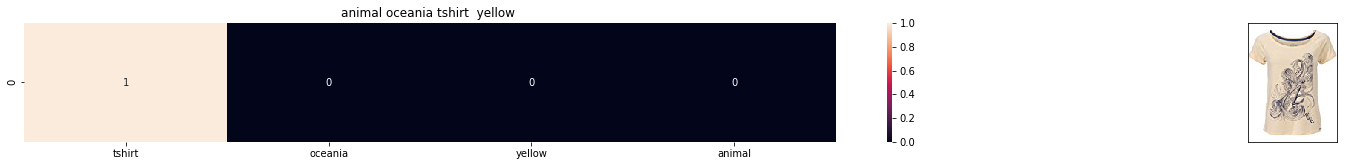

('ASIN :', u'B06X6GX6WG')
('Brand:', u'Animal')
('Title:', u'animal oceania tshirt  yellow ')
('Euclidean similarity with the query image :', 3.1622776601683795)


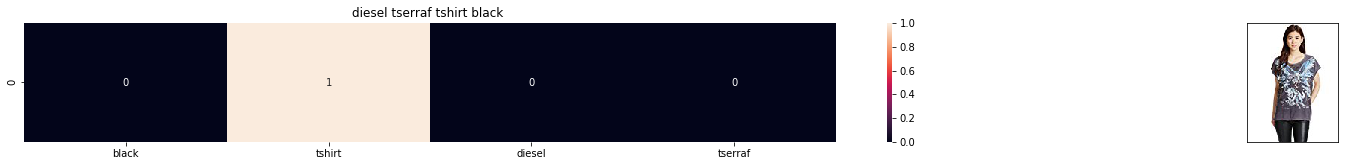

('ASIN :', u'B017X8PW9U')
('Brand:', u'Diesel')
('Title:', u'diesel tserraf tshirt black ')
('Euclidean similarity with the query image :', 3.1622776601683795)


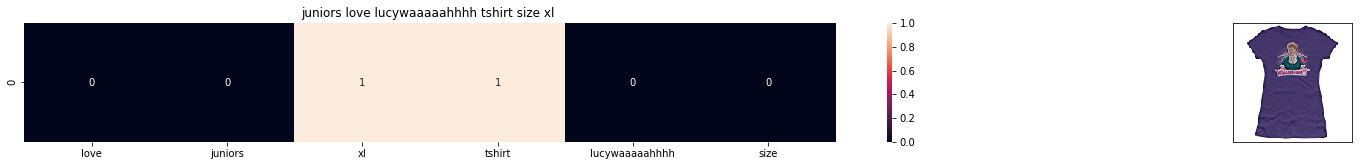

('ASIN :', u'B00IAA4JIQ')
('Brand:', u'I Love Lucy')
('Title:', u'juniors love lucywaaaaahhhh tshirt size xl ')
('Euclidean similarity with the query image :', 3.1622776601683795)


In [30]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    # flatten return a 1 D array in sorted manner
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

In [31]:
#TF-IDF
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

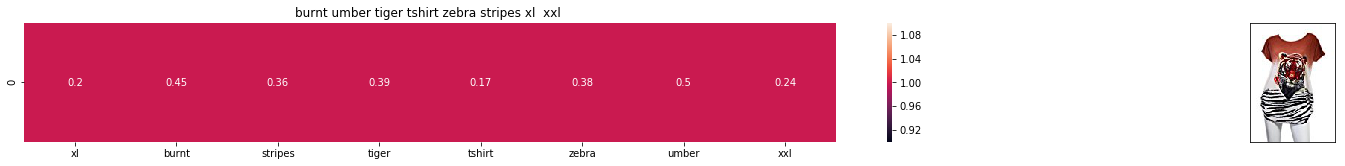

('ASIN :', u'B00JXQB5FQ')
('BRAND :', u'Si Row')
('Eucliden distance from the given image :', 0.0)


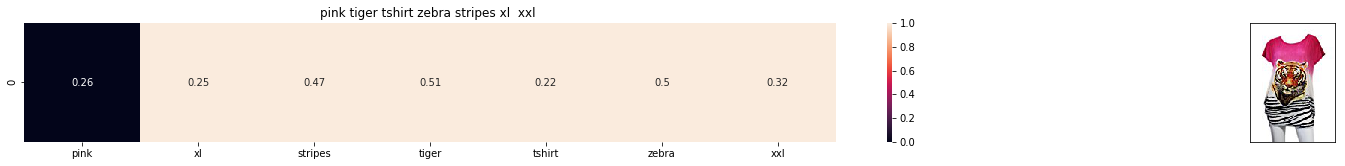

('ASIN :', u'B00JXQASS6')
('BRAND :', u'Si Row')
('Eucliden distance from the given image :', 0.75363319124513606)


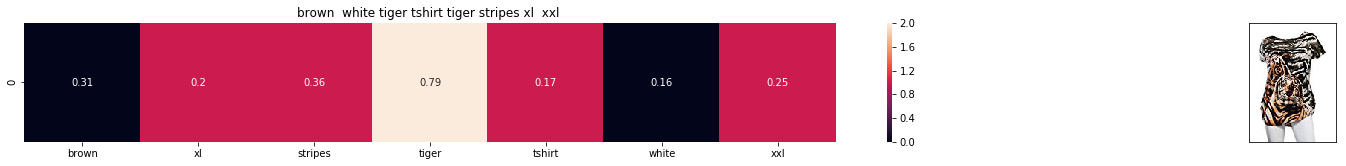

('ASIN :', u'B00JXQCWTO')
('BRAND :', u'Si Row')
('Eucliden distance from the given image :', 0.93576439437696457)


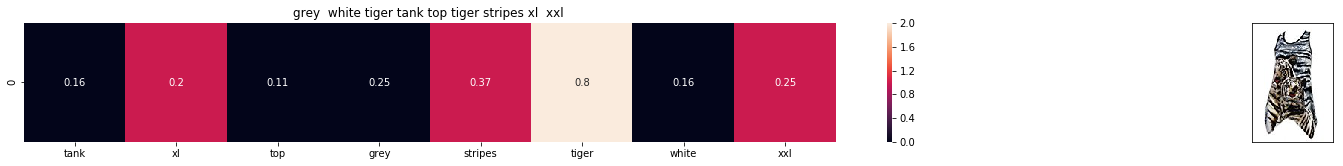

('ASIN :', u'B00JXQAFZ2')
('BRAND :', u'Si Row')
('Eucliden distance from the given image :', 0.95861535242007478)


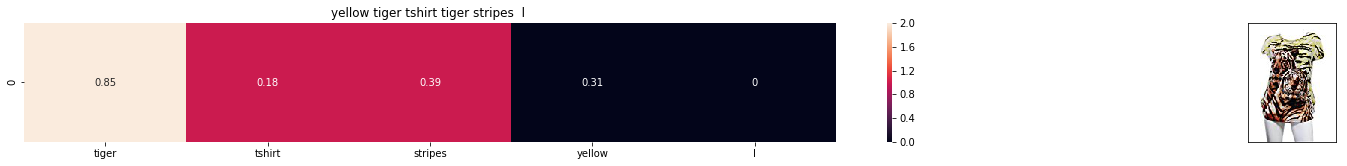

('ASIN :', u'B00JXQCUIC')
('BRAND :', u'Si Row')
('Eucliden distance from the given image :', 1.0000749614468809)


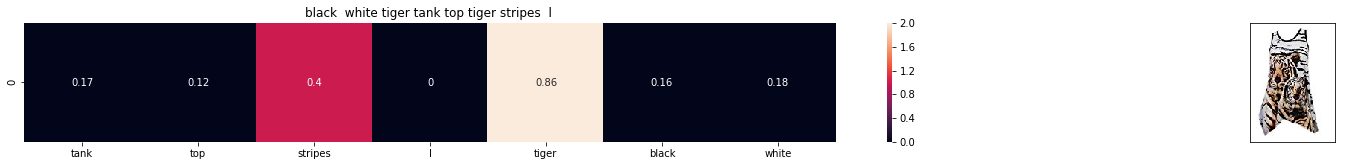

('ASIN :', u'B00JXQAO94')
('BRAND :', u'Si Row')
('Eucliden distance from the given image :', 1.023215552457452)


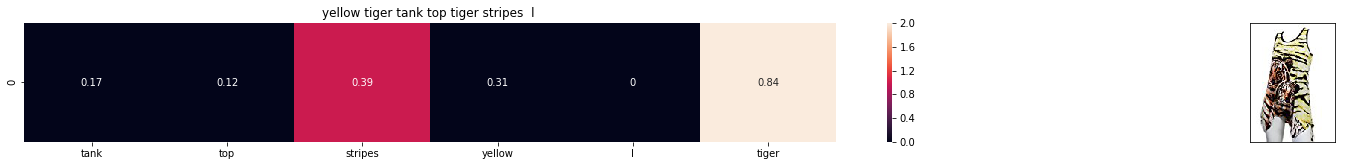

('ASIN :', u'B00JXQAUWA')
('BRAND :', u'Si Row')
('Eucliden distance from the given image :', 1.0319918463034212)


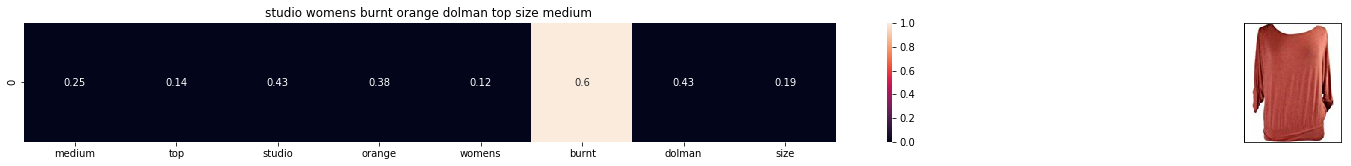

('ASIN :', u'B06XSCVFT5')
('BRAND :', u'Studio M')
('Eucliden distance from the given image :', 1.2106843670424716)


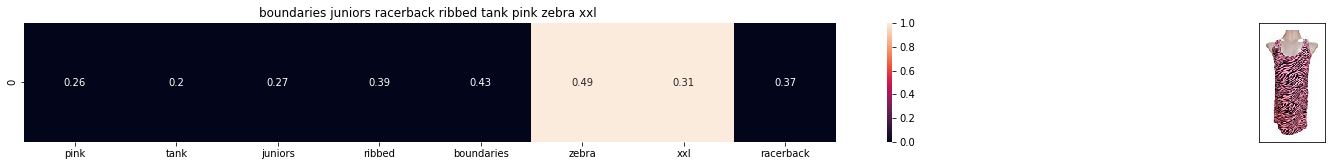

('ASIN :', u'B06Y2GTYPM')
('BRAND :', u'No Boundaries')
('Eucliden distance from the given image :', 1.2121683810720829)


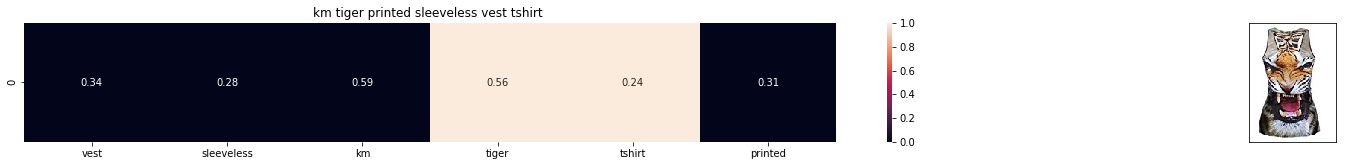

('ASIN :', u'B012VQLT6Y')
('BRAND :', u'KM T-shirt')
('Eucliden distance from the given image :', 1.2197906402809819)


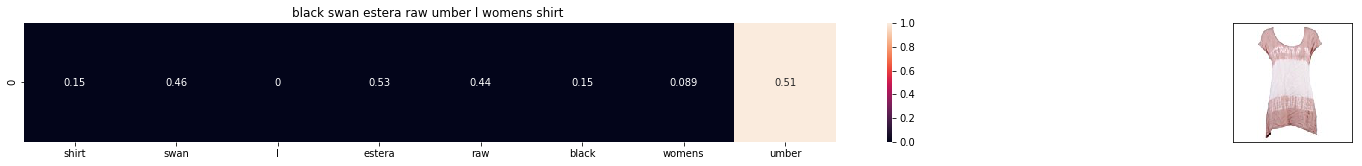

('ASIN :', u'B06Y1VN8WQ')
('BRAND :', u'Black Swan')
('Eucliden distance from the given image :', 1.2206849659998316)


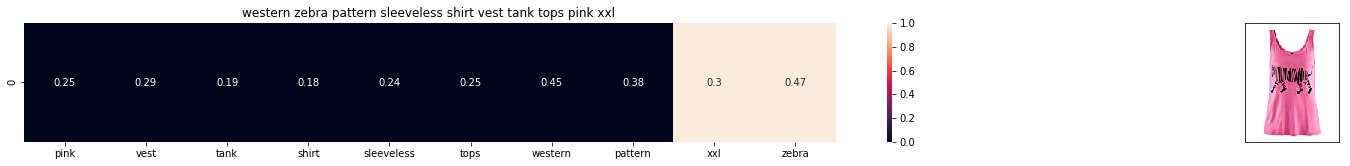

('ASIN :', u'B00Z6HEXWI')
('BRAND :', u'Black Temptation')
('Eucliden distance from the given image :', 1.2212813921209431)


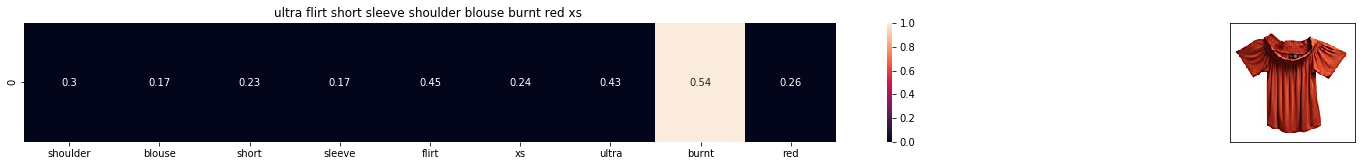

('ASIN :', u'B074TR12BH')
('BRAND :', u'Ultra Flirt')
('Eucliden distance from the given image :', 1.2313364094597743)


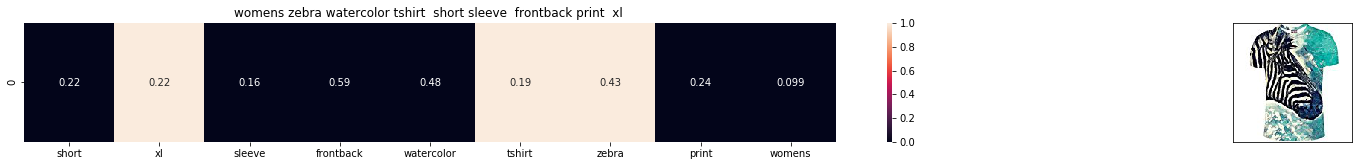

('ASIN :', u'B072R2JXKW')
('BRAND :', u'WHAT ON EARTH')
('Eucliden distance from the given image :', 1.2318451972624518)


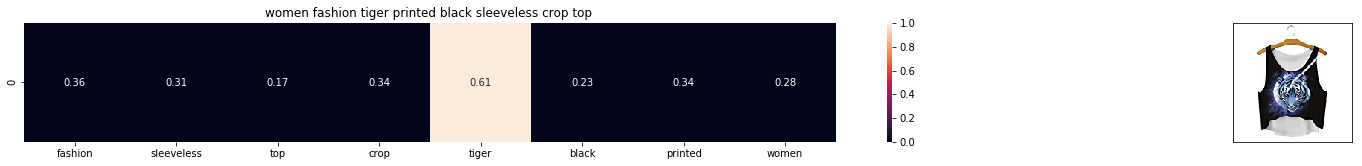

('ASIN :', u'B074T8ZYGX')
('BRAND :', u'MKP Crop Top')
('Eucliden distance from the given image :', 1.2340607457359425)


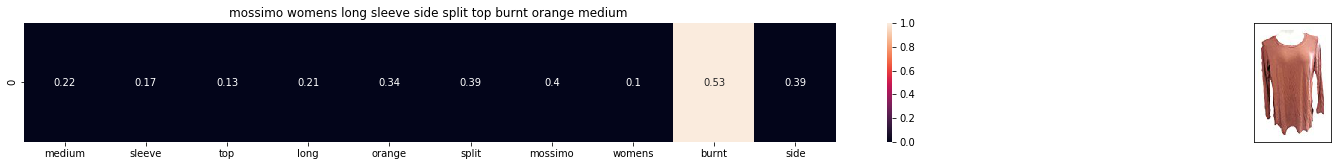

('ASIN :', u'B071ZDF6T2')
('BRAND :', u'Mossimo')
('Eucliden distance from the given image :', 1.2352785577664824)


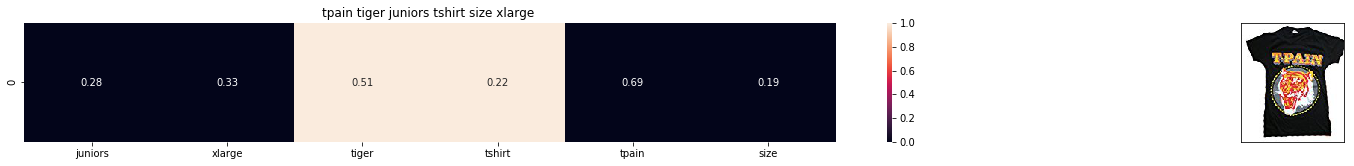

('ASIN :', u'B01K0H02OG')
('BRAND :', u'Tultex')
('Eucliden distance from the given image :', 1.2364572988127822)


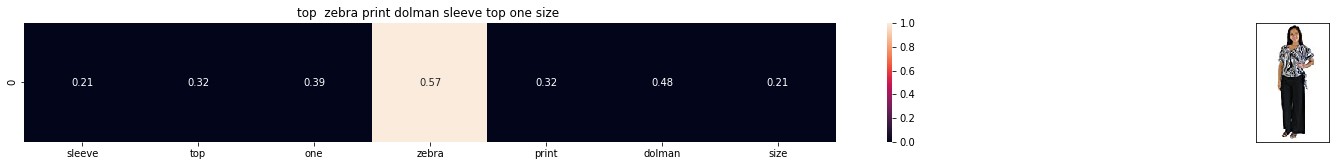

('ASIN :', u'B00H8A6ZLI')
('BRAND :', u"Vivian's Fashions")
('Eucliden distance from the given image :', 1.24996155052848)


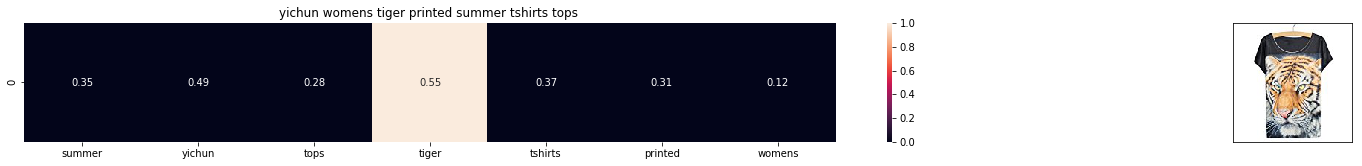

('ASIN :', u'B010NN9RXO')
('BRAND :', u'YICHUN')
('Eucliden distance from the given image :', 1.25354614208561)


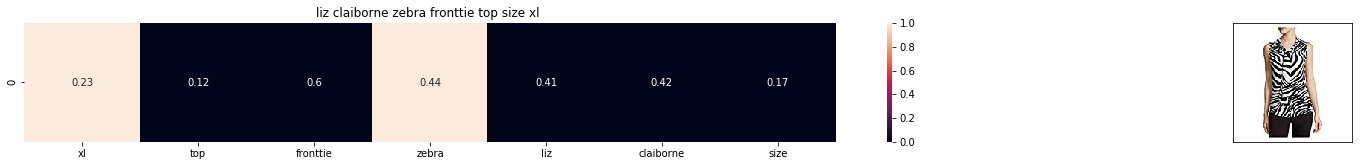

('ASIN :', u'B06XBY5QXL')
('BRAND :', u'Liz Claiborne')
('Eucliden distance from the given image :', 1.2538832938357722)


In [32]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

In [33]:
#IDF ONLY
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [34]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [36]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

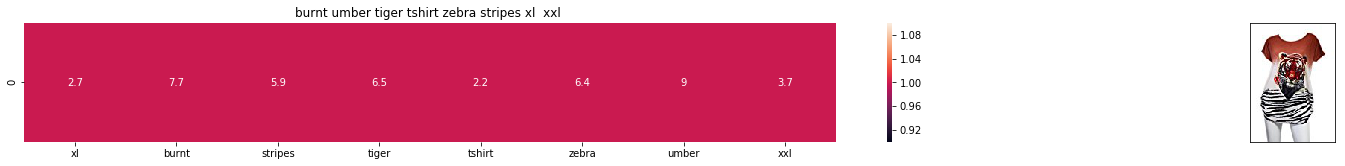

('ASIN :', u'B00JXQB5FQ')
('Brand :', u'Si Row')
('euclidean distance from the given image :', 0.0)


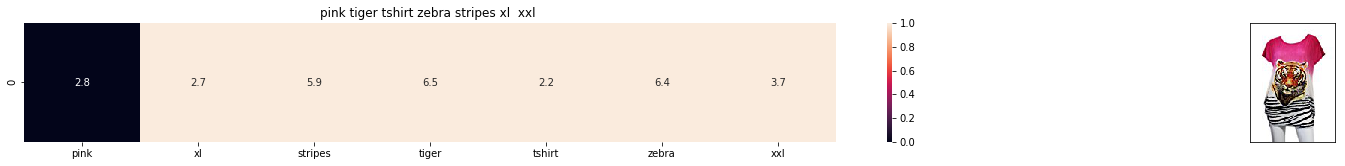

('ASIN :', u'B00JXQASS6')
('Brand :', u'Si Row')
('euclidean distance from the given image :', 12.194307491238892)


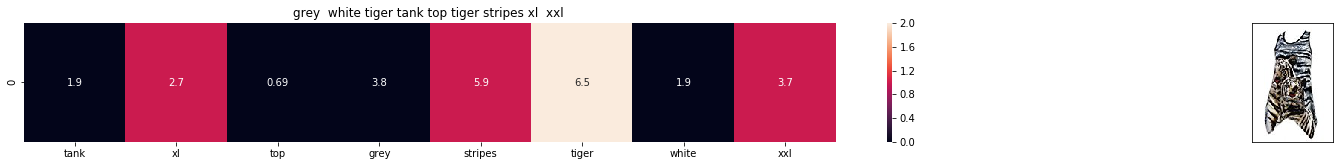

('ASIN :', u'B00JXQAFZ2')
('Brand :', u'Si Row')
('euclidean distance from the given image :', 14.439330751870177)


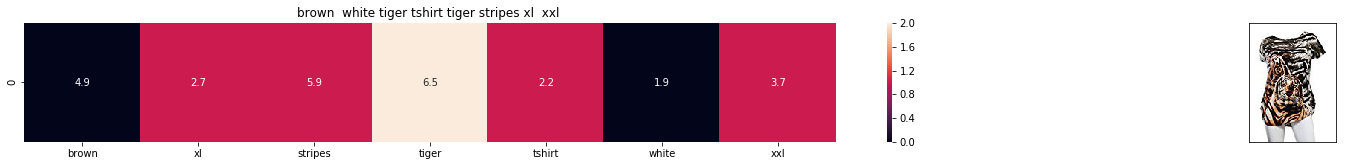

('ASIN :', u'B00JXQCWTO')
('Brand :', u'Si Row')
('euclidean distance from the given image :', 14.449741477557215)


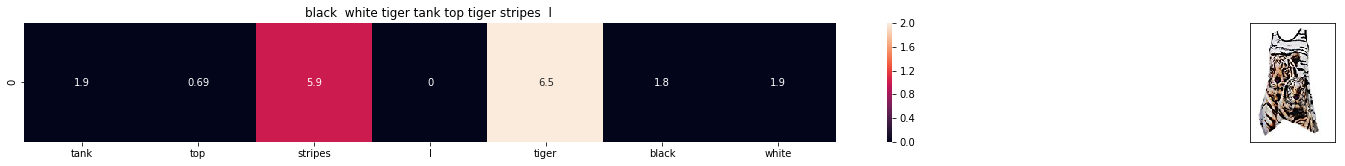

('ASIN :', u'B00JXQAO94')
('Brand :', u'Si Row')
('euclidean distance from the given image :', 14.775427847404648)


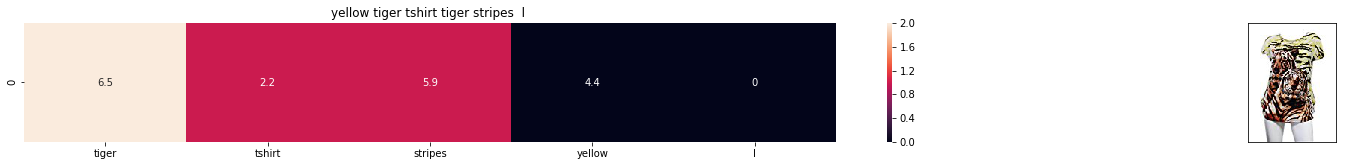

('ASIN :', u'B00JXQCUIC')
('Brand :', u'Si Row')
('euclidean distance from the given image :', 14.883973527849752)


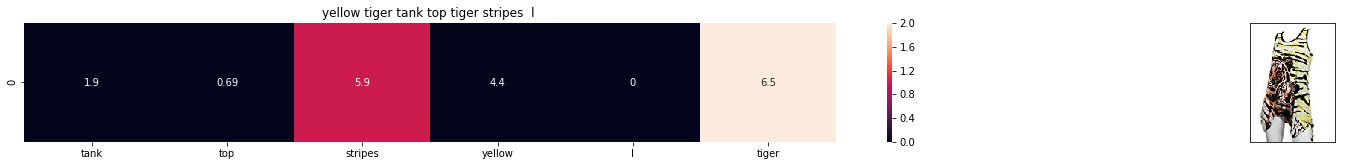

('ASIN :', u'B00JXQAUWA')
('Brand :', u'Si Row')
('euclidean distance from the given image :', 15.186424304065035)


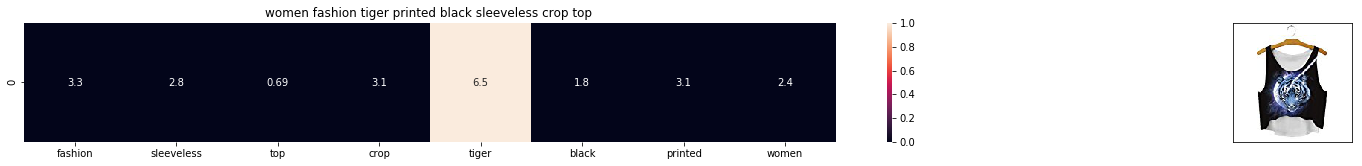

('ASIN :', u'B074T8ZYGX')
('Brand :', u'MKP Crop Top')
('euclidean distance from the given image :', 17.021161652834778)


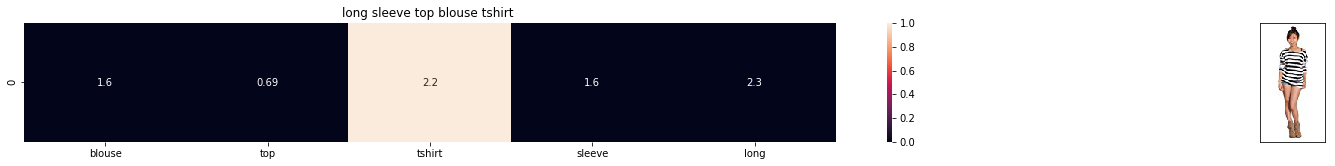

('ASIN :', u'B00KF2N5PU')
('Brand :', u'Vietsbay')
('euclidean distance from the given image :', 17.037212357075308)


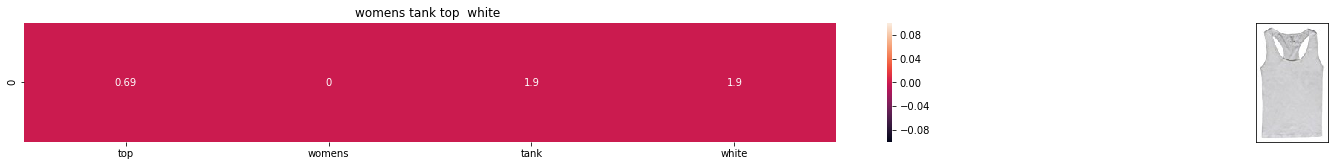

('ASIN :', u'B00JPOZ9GM')
('Brand :', u'Sofra')
('euclidean distance from the given image :', 17.093421379620992)


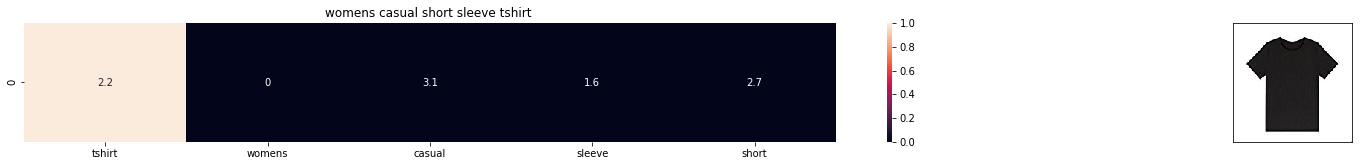

('ASIN :', u'B074T9KG9Q')
('Brand :', u'Rain')
('euclidean distance from the given image :', 17.293317300376977)


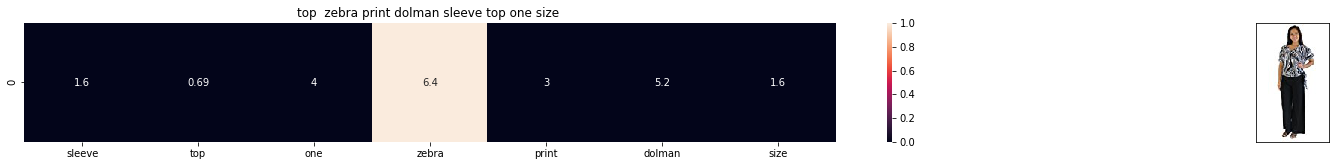

('ASIN :', u'B00H8A6ZLI')
('Brand :', u"Vivian's Fashions")
('euclidean distance from the given image :', 17.351907672674162)


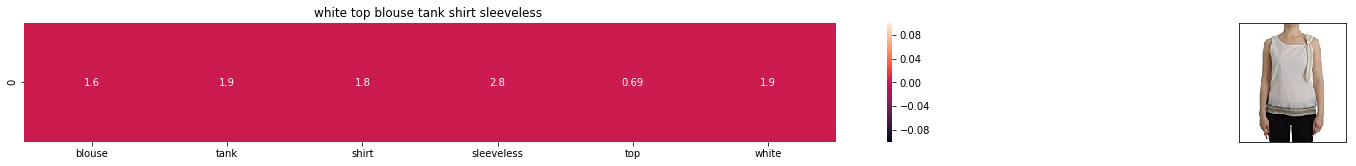

('ASIN :', u'B074G5G5RK')
('Brand :', u'ERMANNO SCERVINO')
('euclidean distance from the given image :', 17.483506372393492)


ConnectionError: ('Connection aborted.', BadStatusLine("''",))

In [37]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

In [40]:
#Text Semantics based product similarity
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model_py2', 'rb') as handle:
    model = pickle.load(handle)

In [41]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [42]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [44]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


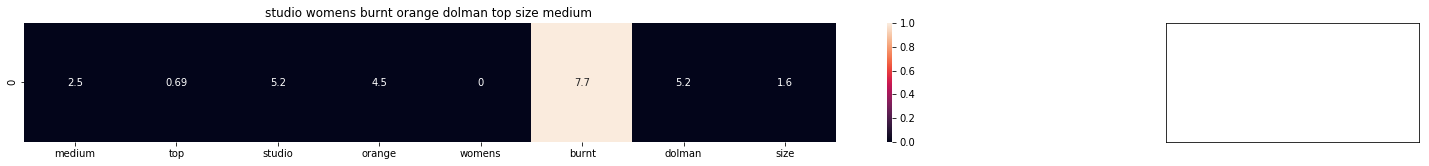

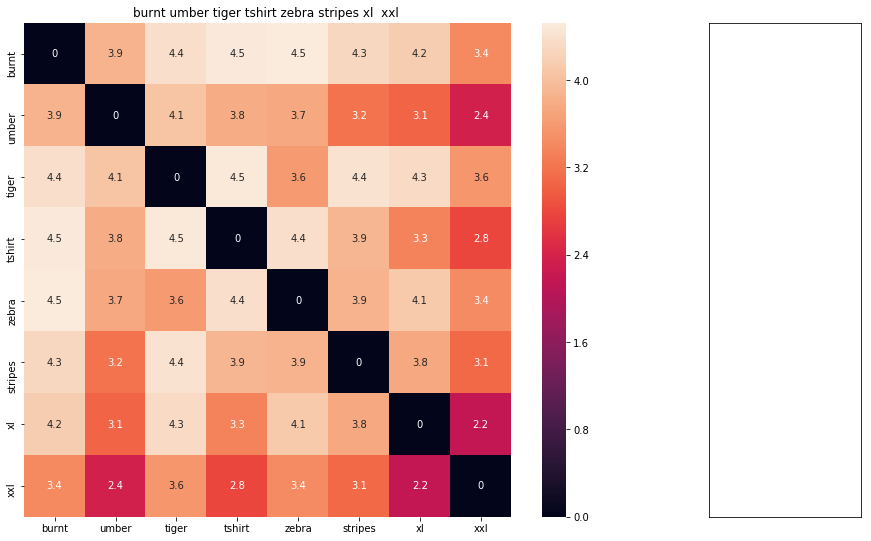

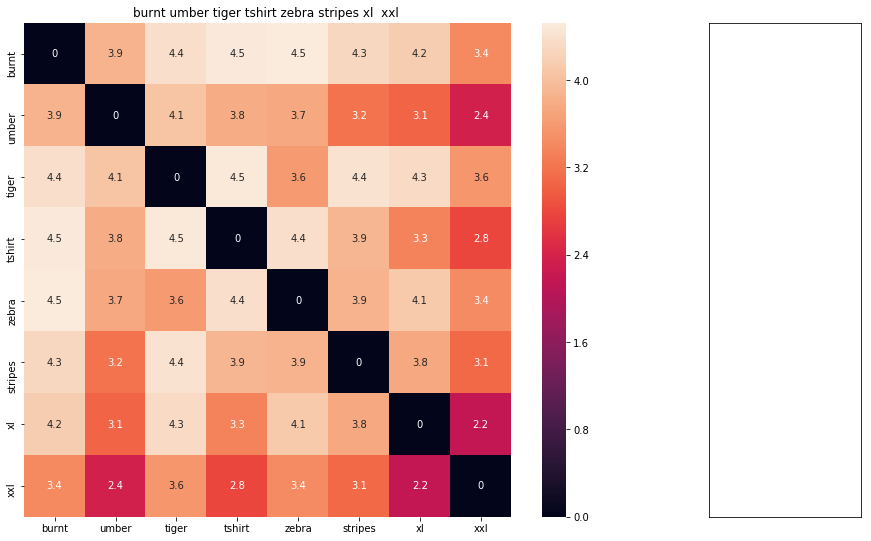

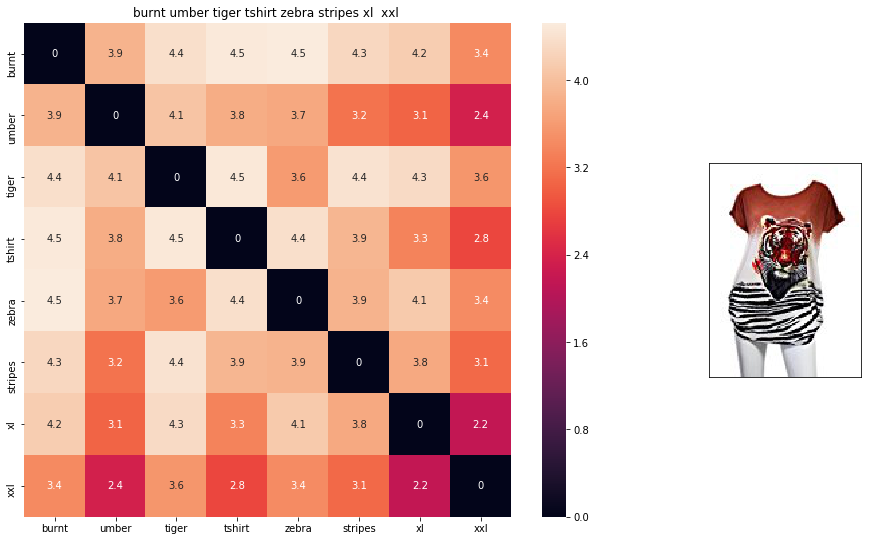

('ASIN :', u'B00JXQB5FQ')
('BRAND :', u'Si Row')
('euclidean distance from given input image :', 0.00069053395)


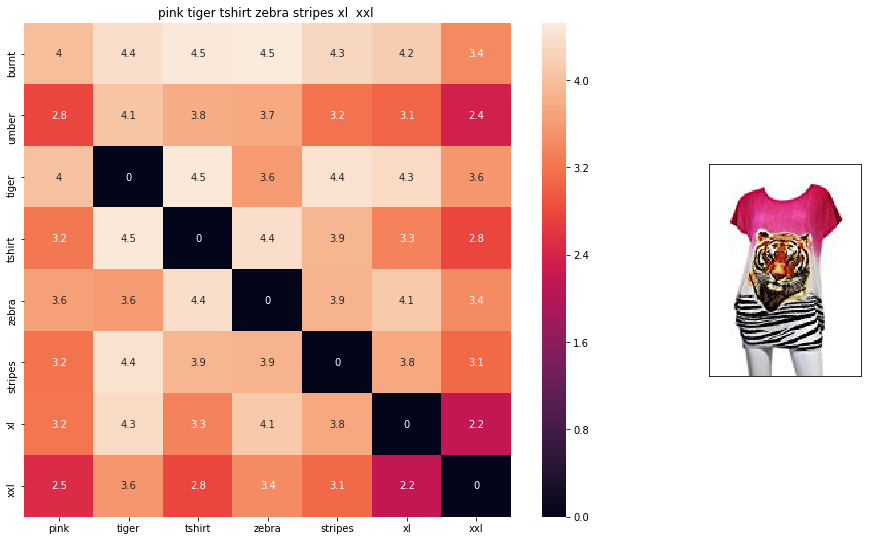

('ASIN :', u'B00JXQASS6')
('BRAND :', u'Si Row')
('euclidean distance from given input image :', 0.58919281)


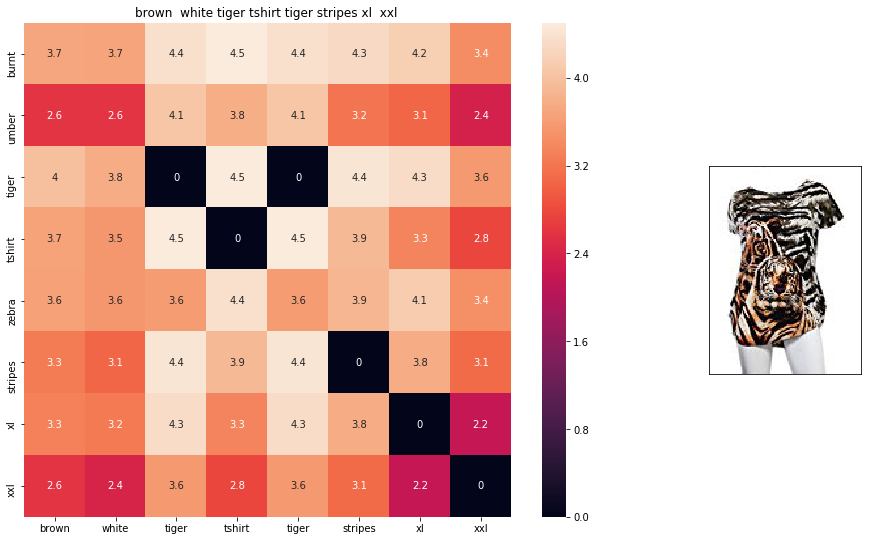

('ASIN :', u'B00JXQCWTO')
('BRAND :', u'Si Row')
('euclidean distance from given input image :', 0.70034391)


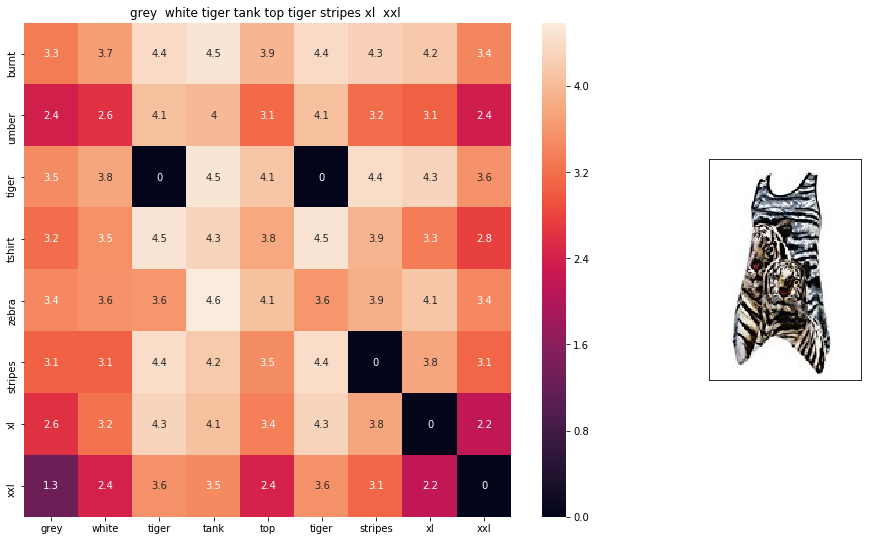

('ASIN :', u'B00JXQAFZ2')
('BRAND :', u'Si Row')
('euclidean distance from given input image :', 0.89283955)


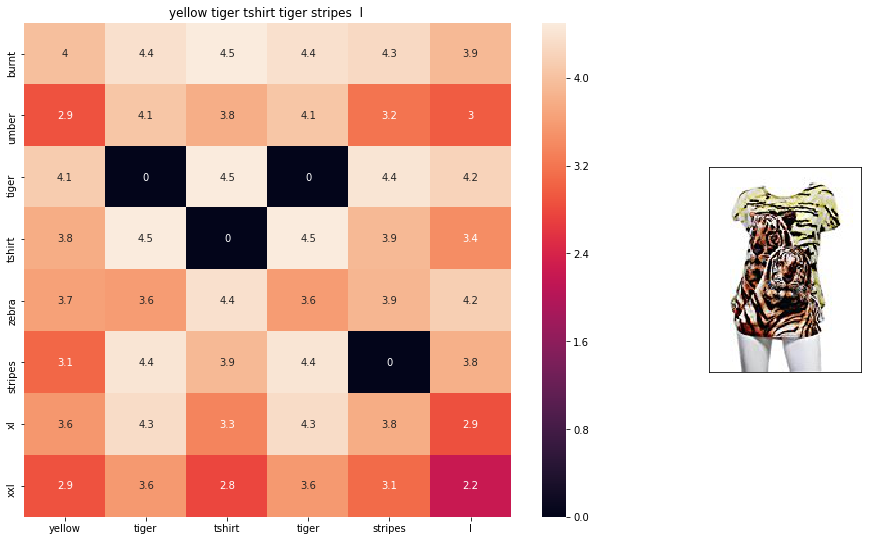

('ASIN :', u'B00JXQCUIC')
('BRAND :', u'Si Row')
('euclidean distance from given input image :', 0.95601314)


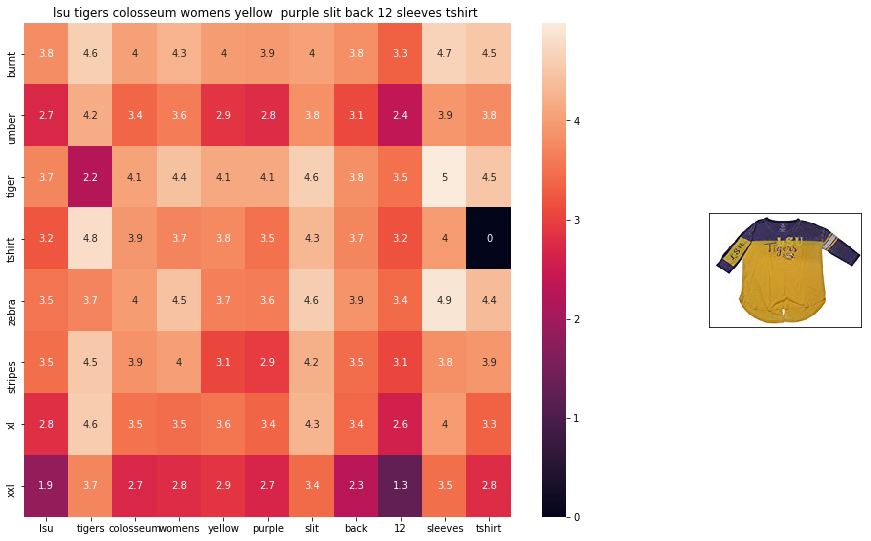

('ASIN :', u'B073R5Q8HD')
('BRAND :', u'Colosseum')
('euclidean distance from given input image :', 1.0229691)


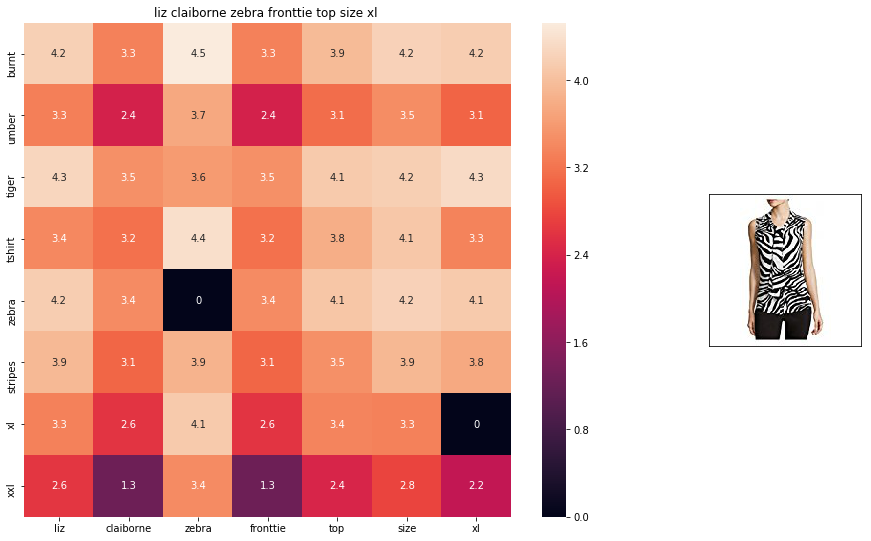

('ASIN :', u'B06XBY5QXL')
('BRAND :', u'Liz Claiborne')
('euclidean distance from given input image :', 1.0669324)


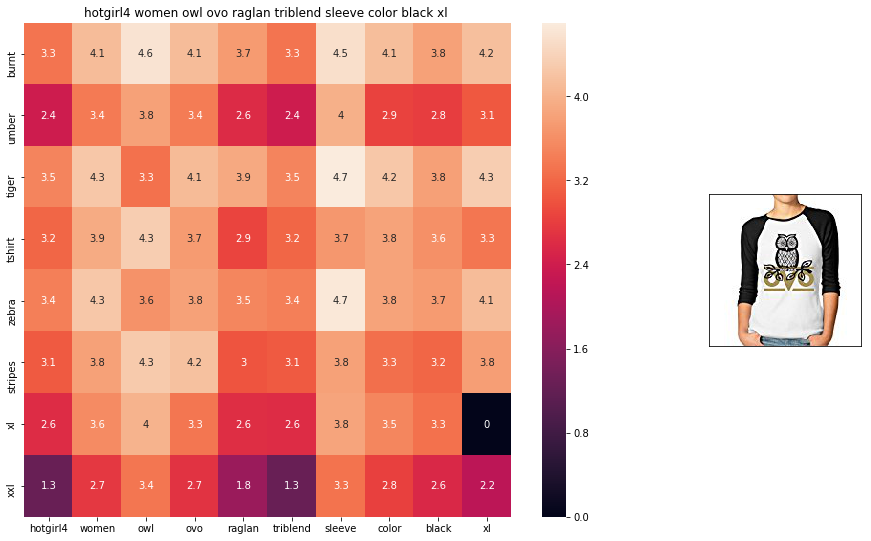

('ASIN :', u'B01L8L73M2')
('BRAND :', u'Hotgirl4 Raglan Design')
('euclidean distance from given input image :', 1.0731407)


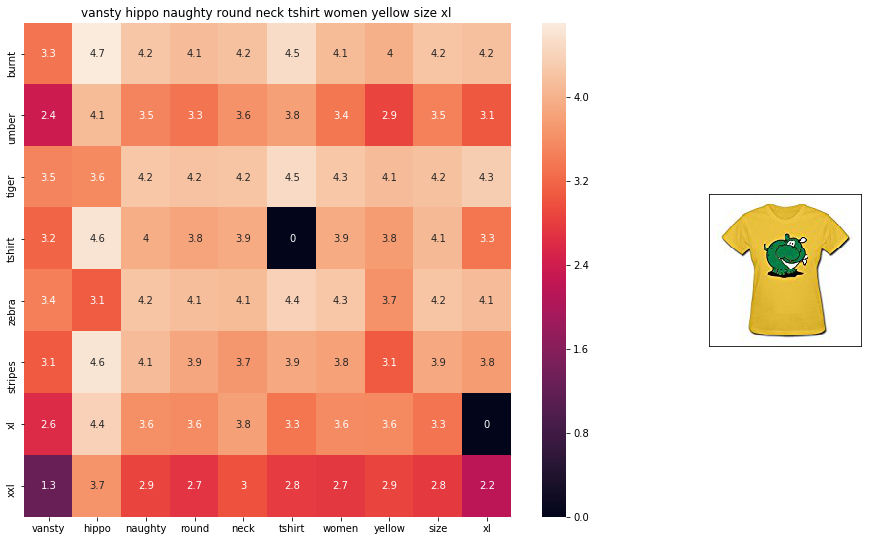

('ASIN :', u'B01EJS5H06')
('BRAND :', u'Vansty')
('euclidean distance from given input image :', 1.075719)


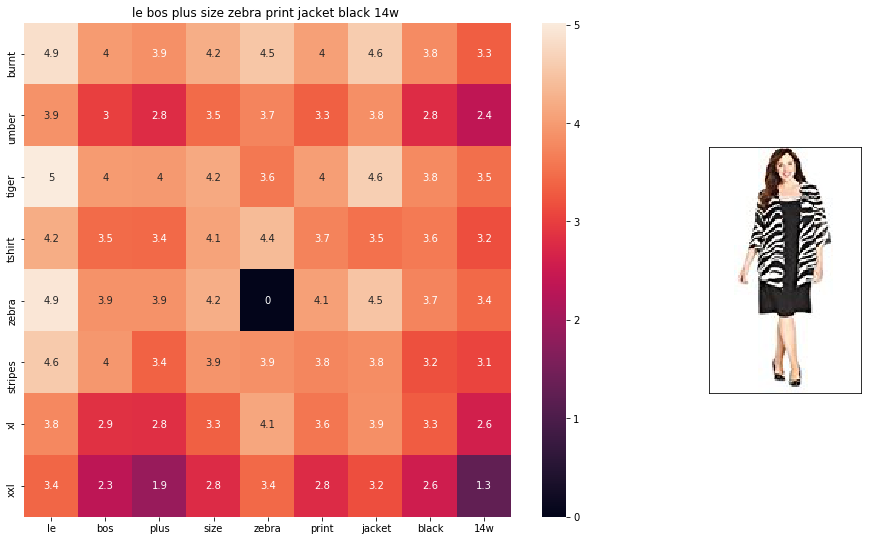

('ASIN :', u'B01BO1XRK8')
('BRAND :', u'Le Bos')
('euclidean distance from given input image :', 1.0839964)


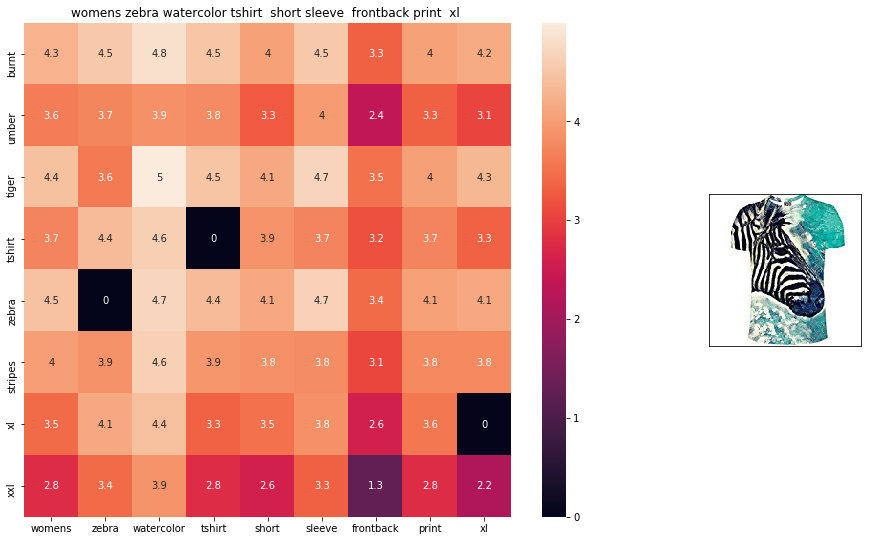

('ASIN :', u'B072R2JXKW')
('BRAND :', u'WHAT ON EARTH')
('euclidean distance from given input image :', 1.0842218)


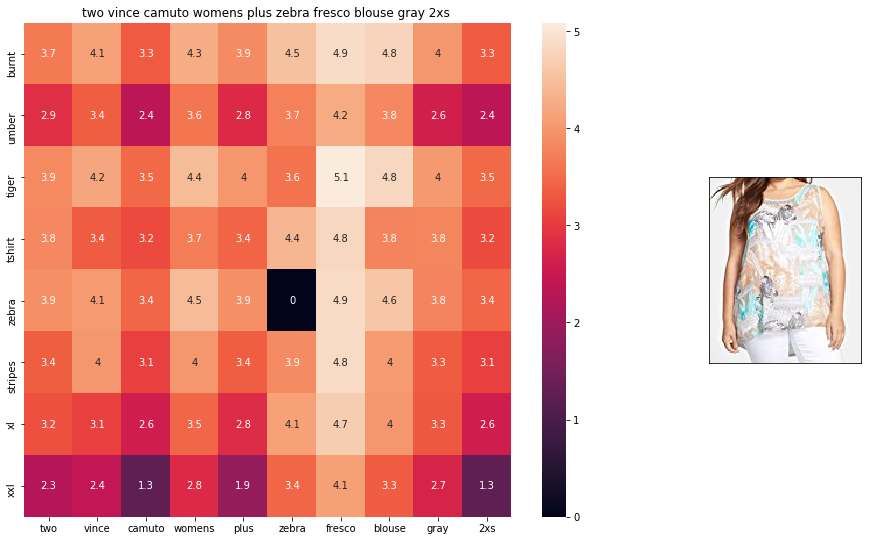

('ASIN :', u'B074MJRGW6')
('BRAND :', u'Two by Vince Camuto')
('euclidean distance from given input image :', 1.0895039)


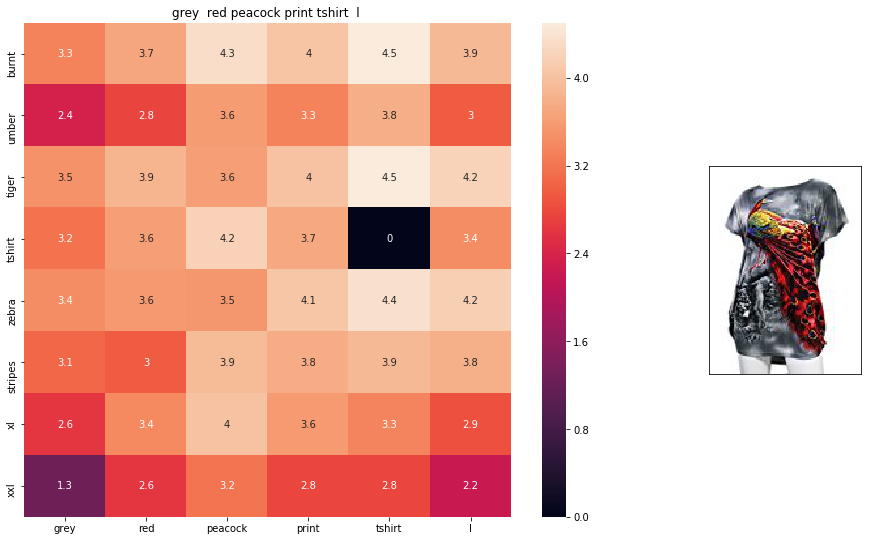

('ASIN :', u'B00JXQCFRS')
('BRAND :', u'Si Row')
('euclidean distance from given input image :', 1.0900586)


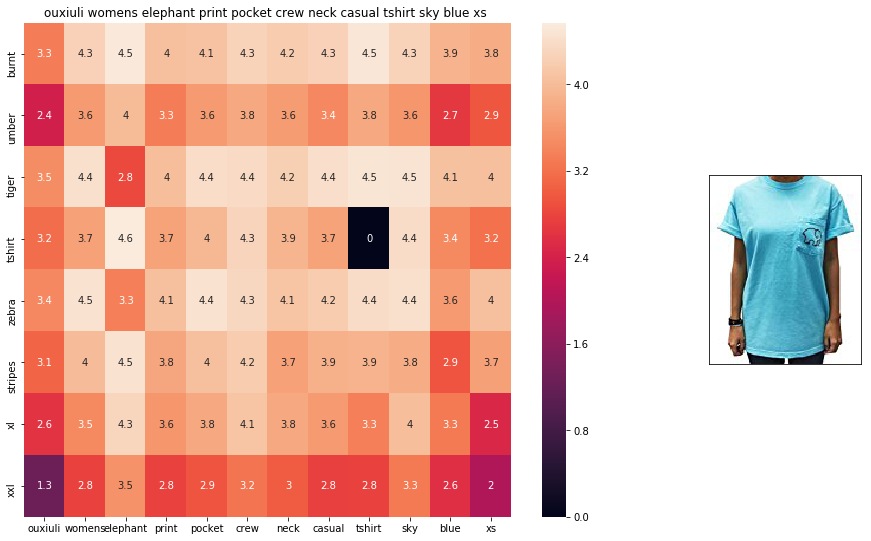

('ASIN :', u'B01I53HU6K')
('BRAND :', u'ouxiuli')
('euclidean distance from given input image :', 1.0920113)


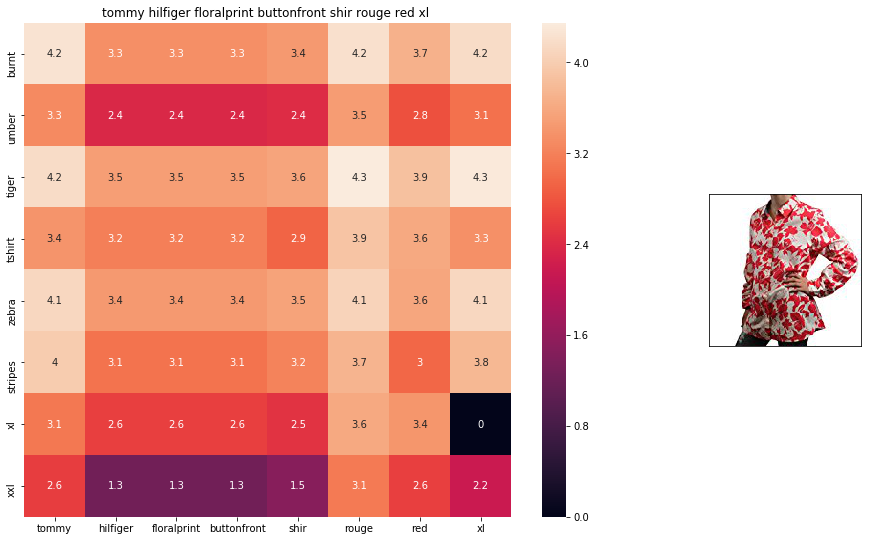

('ASIN :', u'B0711NGTQM')
('BRAND :', u'THILFIGER RTW')
('euclidean distance from given input image :', 1.0923417)


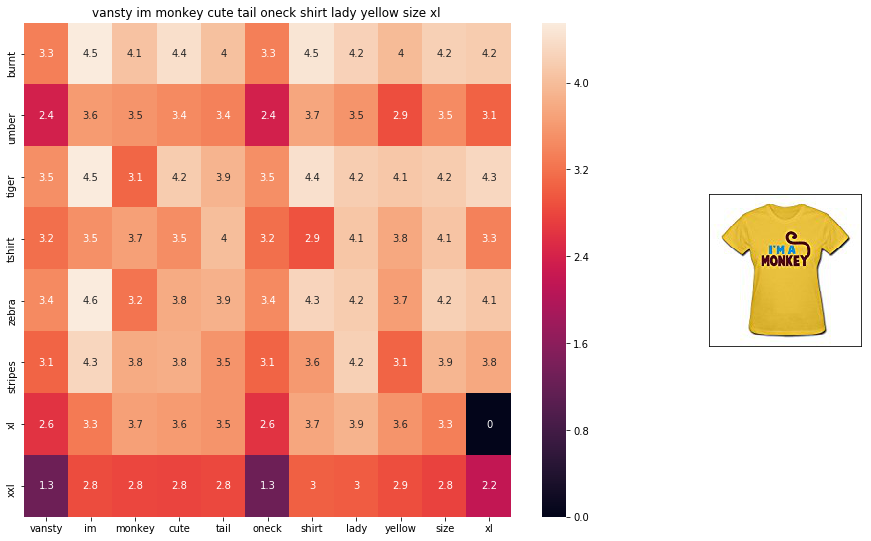

('ASIN :', u'B01EFSLO8Y')
('BRAND :', u'Vansty')
('euclidean distance from given input image :', 1.0934005)


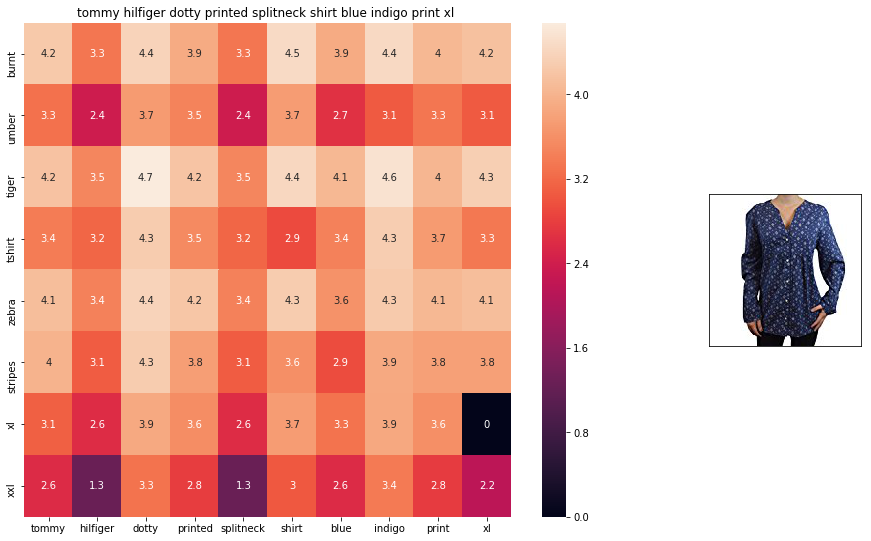

('ASIN :', u'B0716TVWQ4')
('BRAND :', u'THILFIGER RTW')
('euclidean distance from given input image :', 1.0942029)


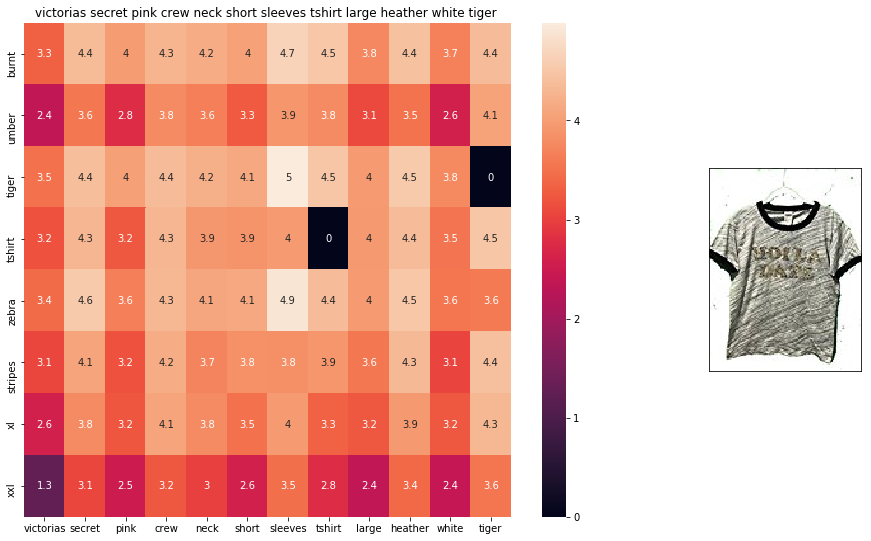

('ASIN :', u'B0716MVPGV')
('BRAND :', u'V.Secret')
('euclidean distance from given input image :', 1.0948308)


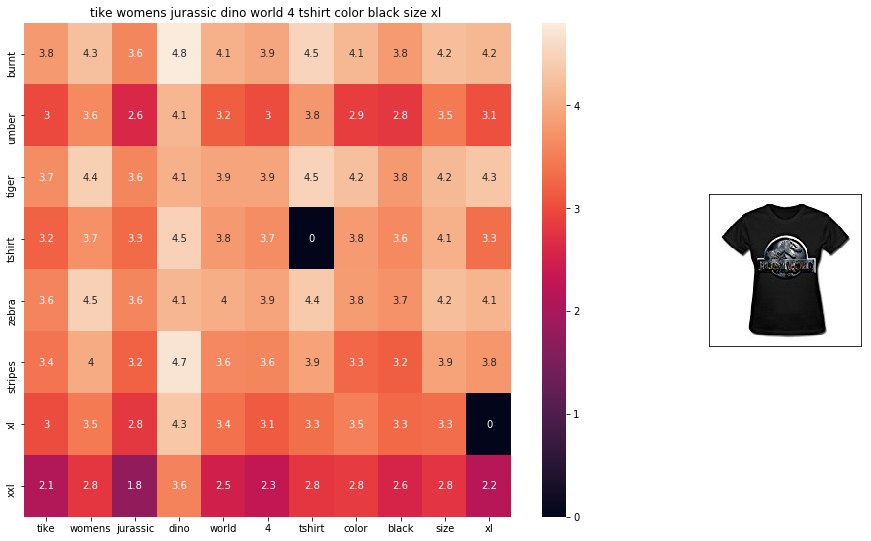

('ASIN :', u'B016OPN4OI')
('BRAND :', u'TIKE Fashions')
('euclidean distance from given input image :', 1.0951277)


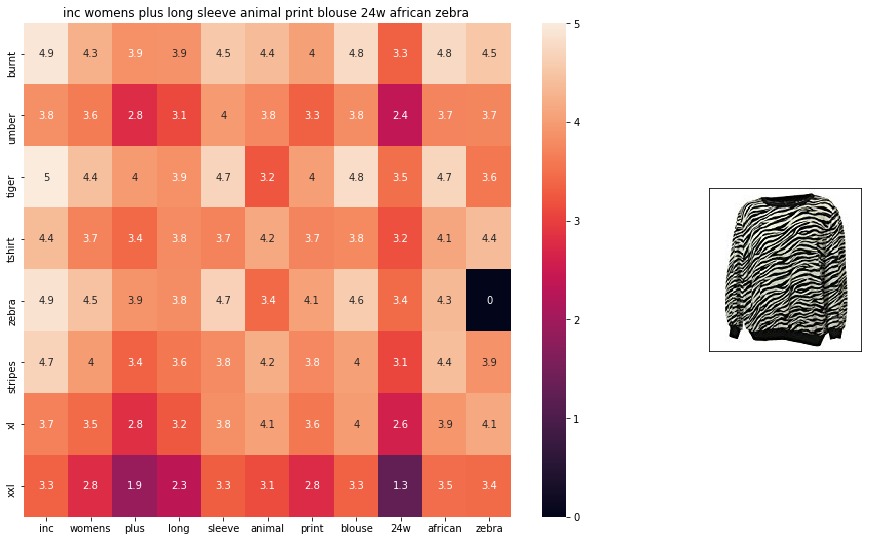

('ASIN :', u'B018WDJCUA')
('BRAND :', u'INC - International Concepts Woman')
('euclidean distance from given input image :', 1.0966892)


In [48]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

In [49]:
#IDF weighted Word2Vec for product similarity

In [50]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

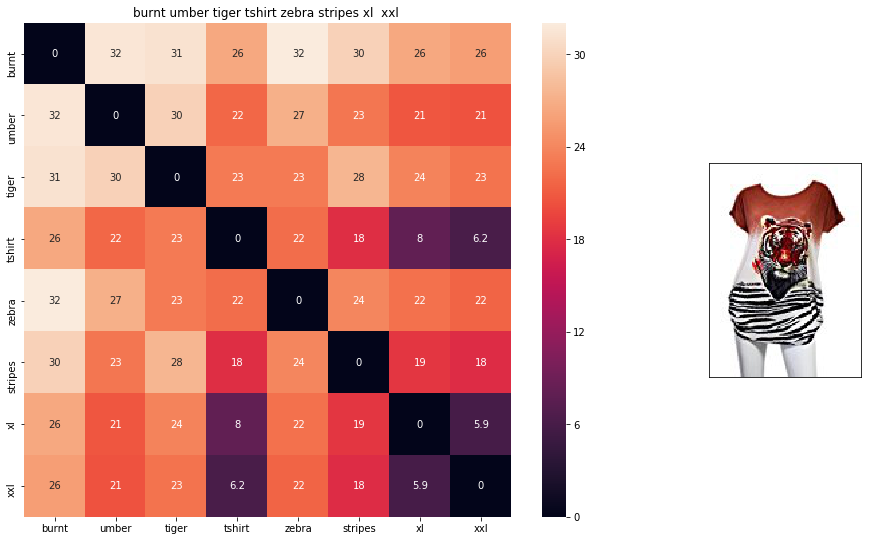

('ASIN :', u'B00JXQB5FQ')
('Brand :', u'Si Row')
('euclidean distance from input :', 0.0)


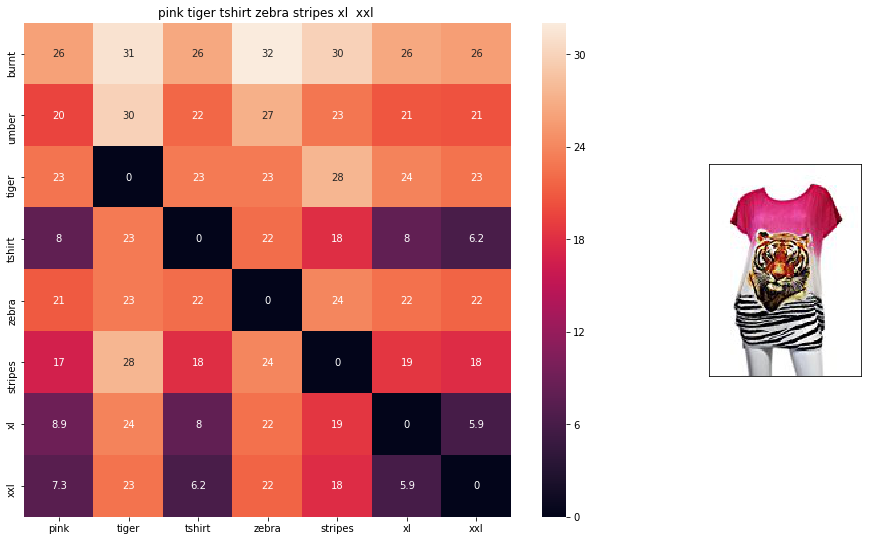

('ASIN :', u'B00JXQASS6')
('Brand :', u'Si Row')
('euclidean distance from input :', 4.063633)


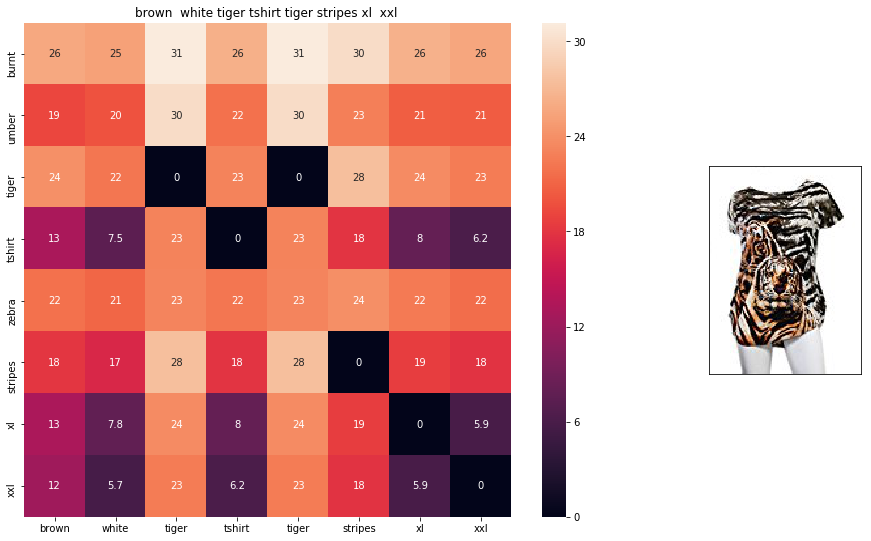

('ASIN :', u'B00JXQCWTO')
('Brand :', u'Si Row')
('euclidean distance from input :', 4.7727876)


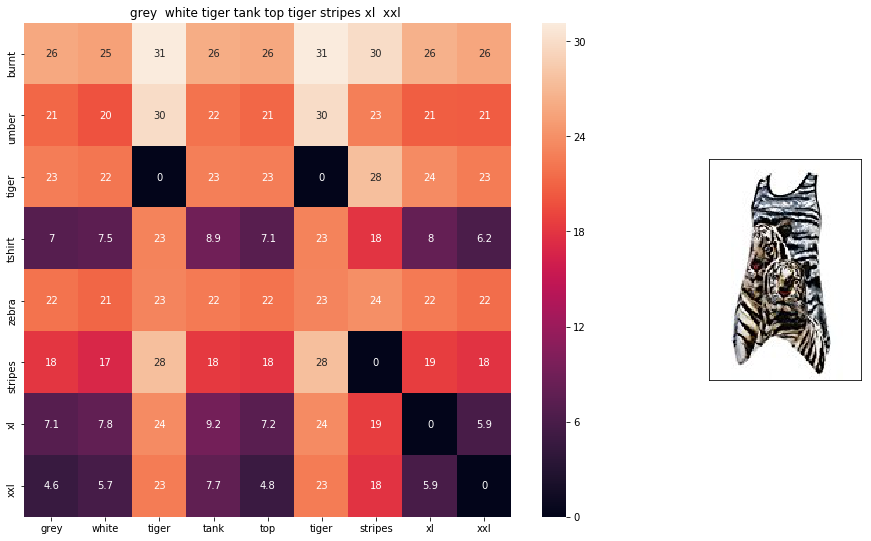

('ASIN :', u'B00JXQAFZ2')
('Brand :', u'Si Row')
('euclidean distance from input :', 5.366497)


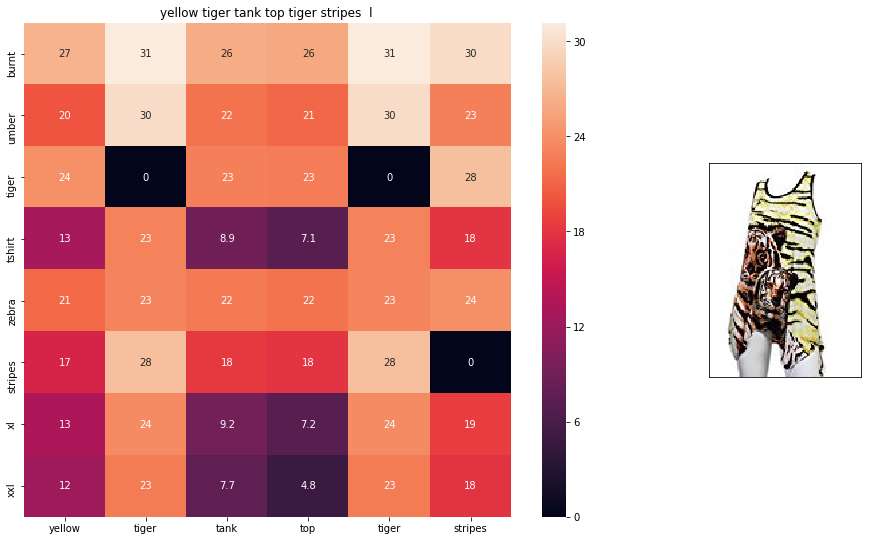

('ASIN :', u'B00JXQAUWA')
('Brand :', u'Si Row')
('euclidean distance from input :', 5.673563)


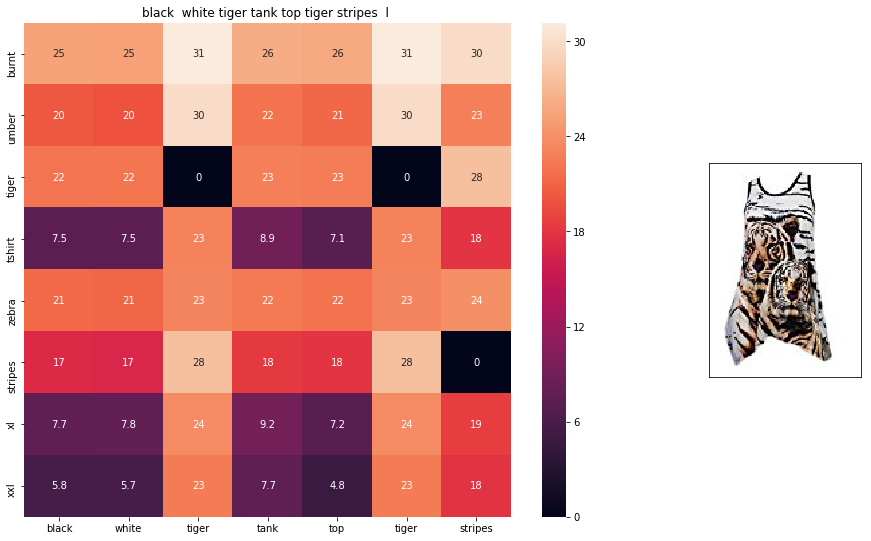

('ASIN :', u'B00JXQAO94')
('Brand :', u'Si Row')
('euclidean distance from input :', 5.6896873)


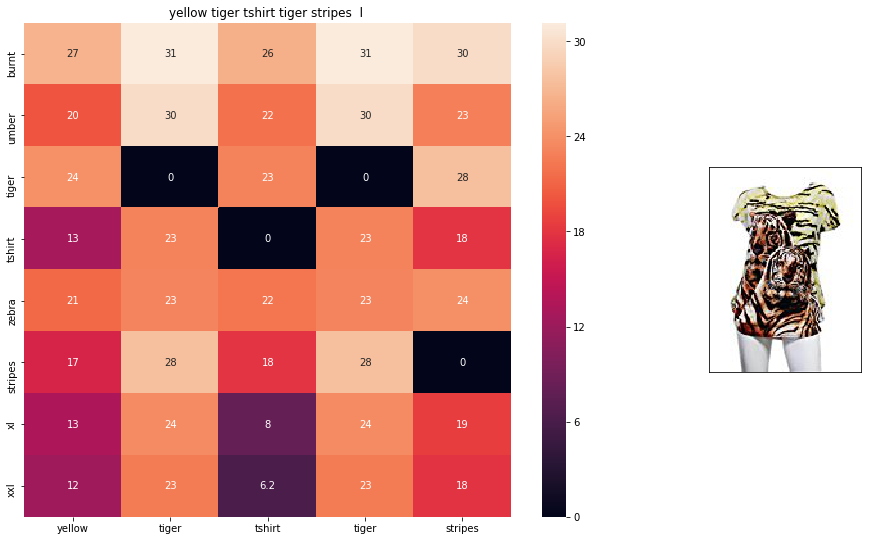

('ASIN :', u'B00JXQCUIC')
('Brand :', u'Si Row')
('euclidean distance from input :', 5.8883138)


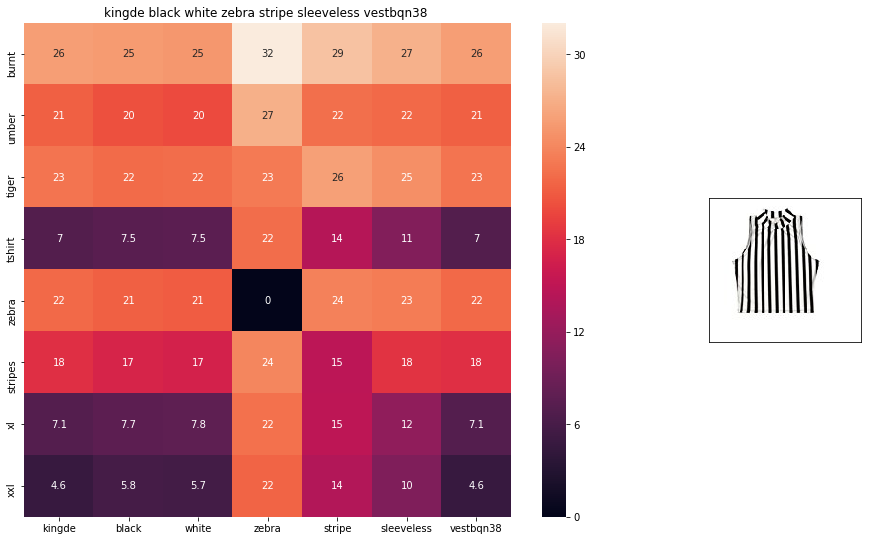

('ASIN :', u'B015H41F6G')
('Brand :', u'KINGDE')
('euclidean distance from input :', 6.1359353)


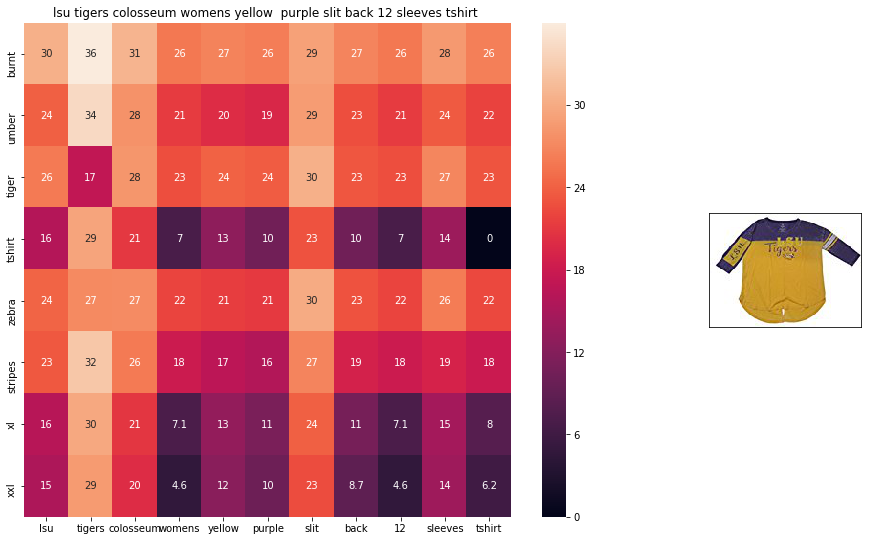

('ASIN :', u'B073R5Q8HD')
('Brand :', u'Colosseum')
('euclidean distance from input :', 6.2525067)


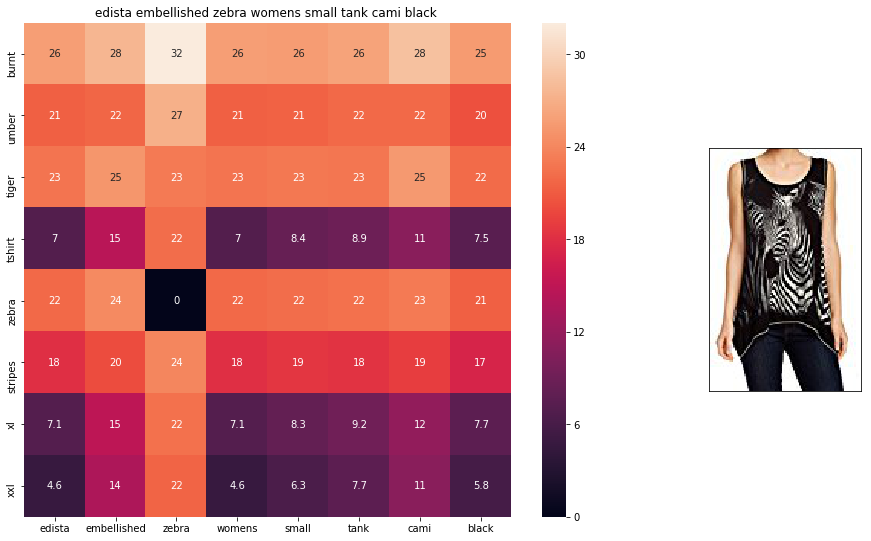

('ASIN :', u'B074P8MD22')
('Brand :', u'Edista')
('euclidean distance from input :', 6.403791)


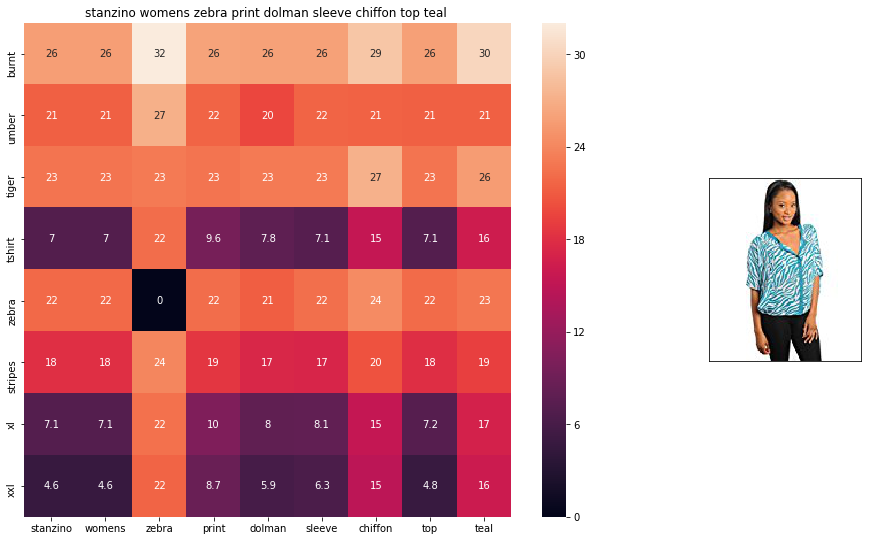

('ASIN :', u'B00C0I3U3E')
('Brand :', u'Stanzino')
('euclidean distance from input :', 6.425766)


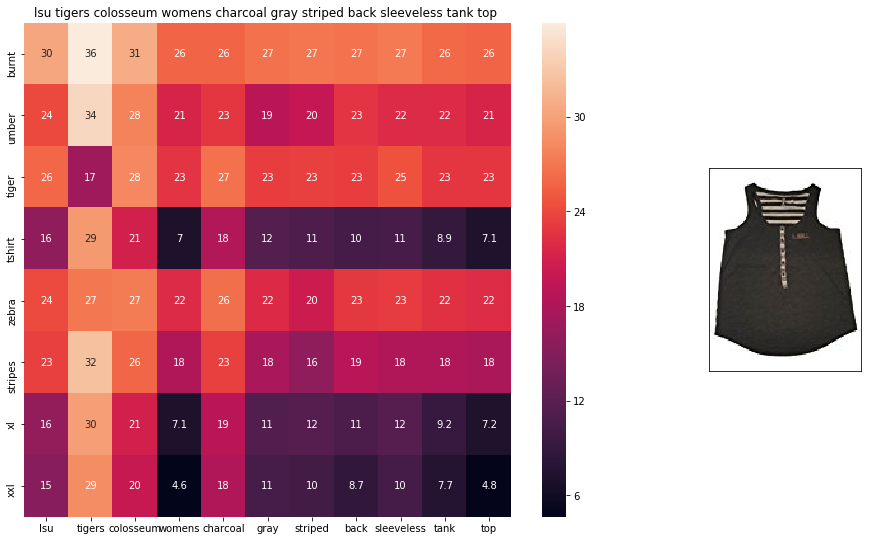

('ASIN :', u'B073R4ZM7Y')
('Brand :', u'Colosseum')
('euclidean distance from input :', 6.4396825)


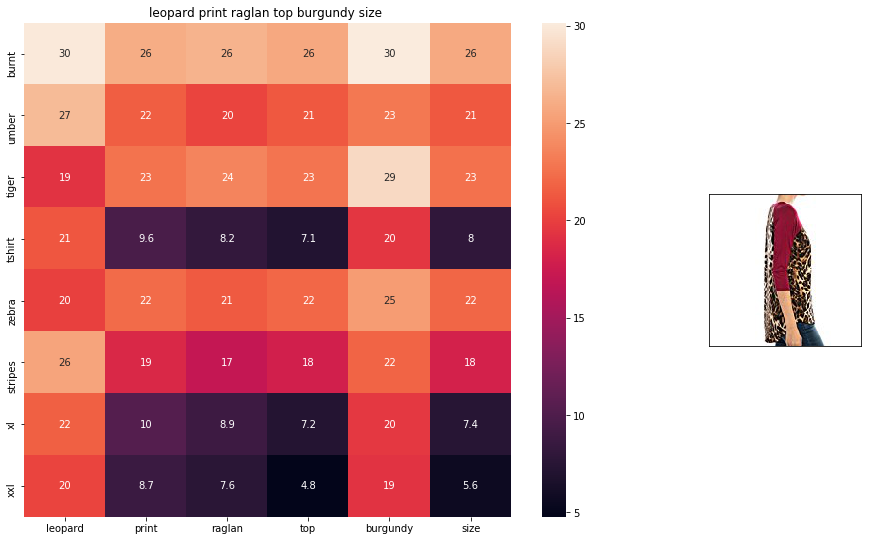

('ASIN :', u'B01C6ORLDQ')
('Brand :', u'1 Mad Fit')
('euclidean distance from input :', 6.4562039)


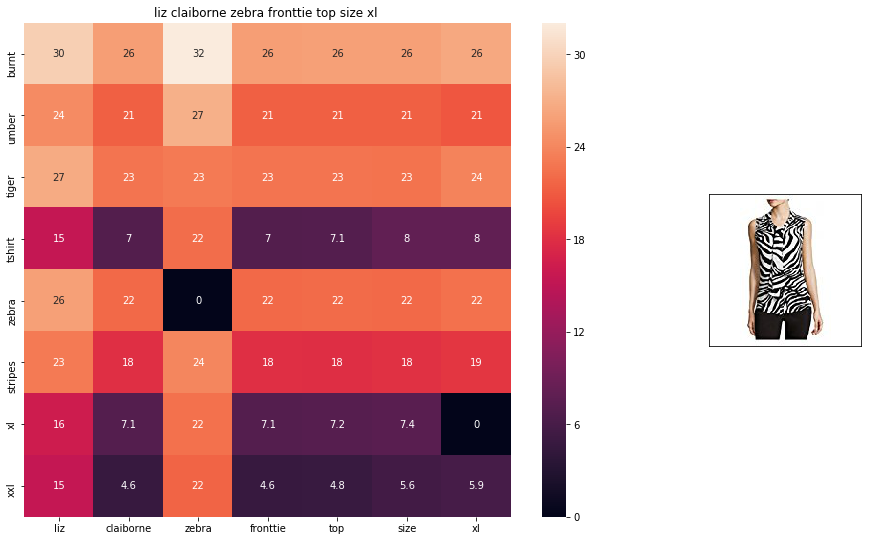

('ASIN :', u'B06XBY5QXL')
('Brand :', u'Liz Claiborne')
('euclidean distance from input :', 6.5473089)


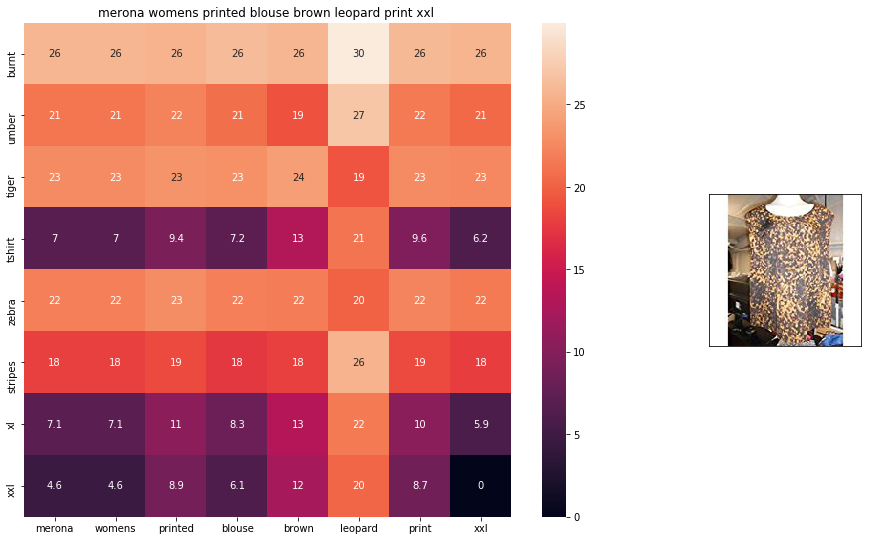

('ASIN :', u'B071YF3WDD')
('Brand :', u'Merona')
('euclidean distance from input :', 6.5759392)


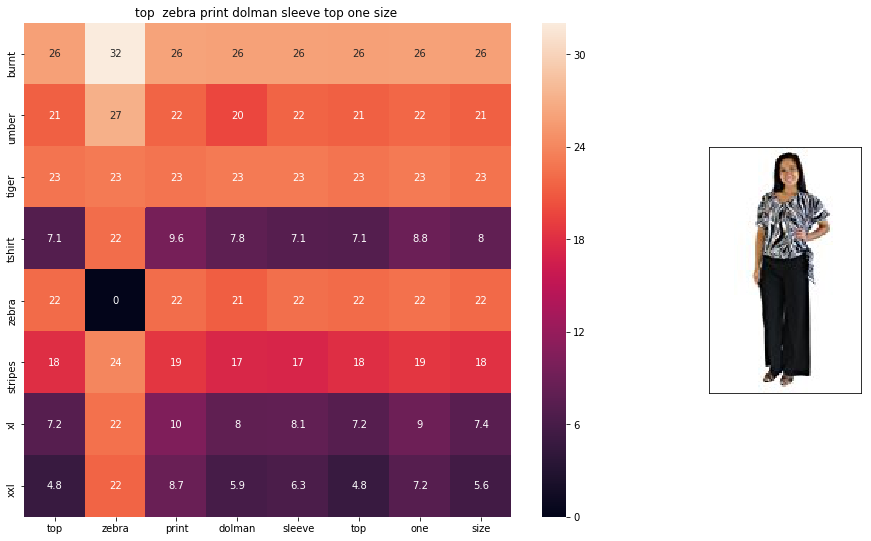

('ASIN :', u'B00H8A6ZLI')
('Brand :', u"Vivian's Fashions")
('euclidean distance from input :', 6.6302028)


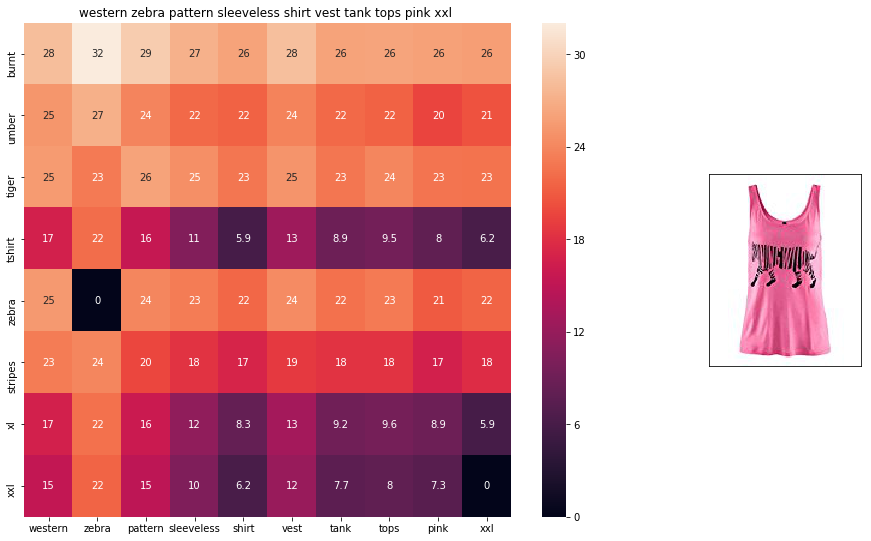

('ASIN :', u'B00Z6HEXWI')
('Brand :', u'Black Temptation')
('euclidean distance from input :', 6.6559052)


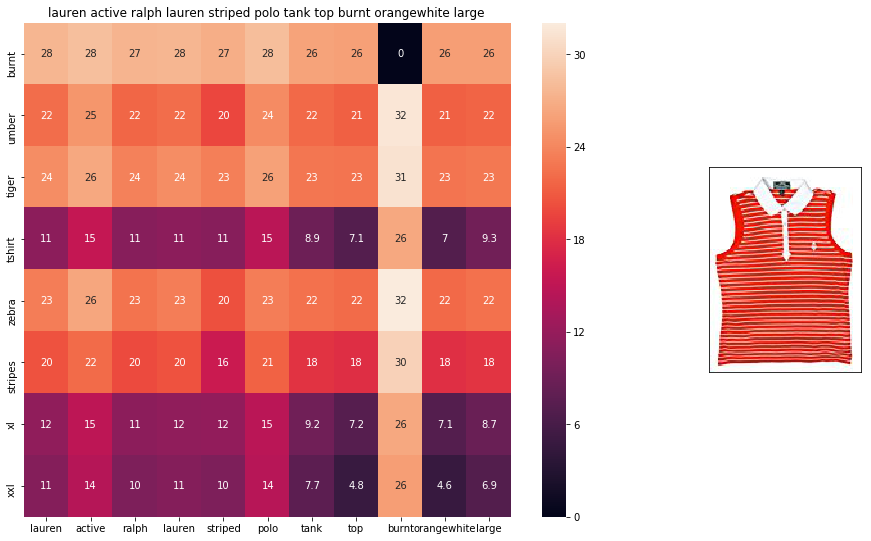

('ASIN :', u'B00ILGH5OY')
('Brand :', u'Ralph Lauren Active')
('euclidean distance from input :', 6.6828356)


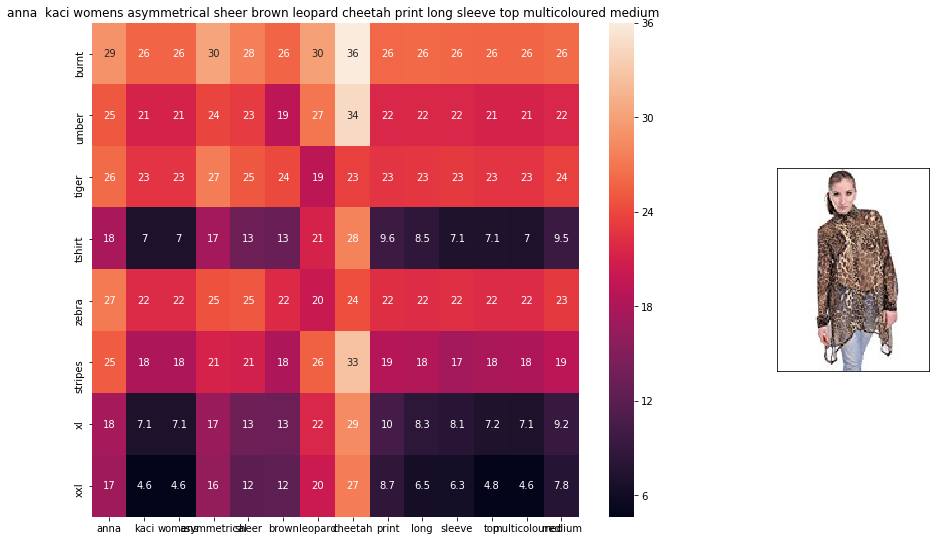

('ASIN :', u'B00KSNTY7Y')
('Brand :', u'Anna-Kaci')
('euclidean distance from input :', 6.7014675)


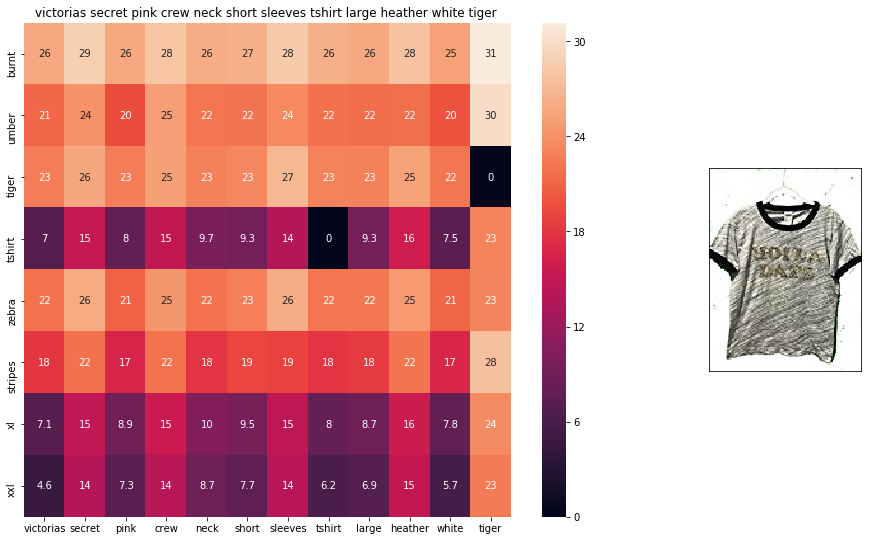

('ASIN :', u'B0716MVPGV')
('Brand :', u'V.Secret')
('euclidean distance from input :', 6.7224088)


In [51]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 20)
#931
#12566
# in the give heat map, each cell contains the euclidean distance between words i, j

In [52]:
## Weighted similarity using brand and color.

In [53]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [54]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

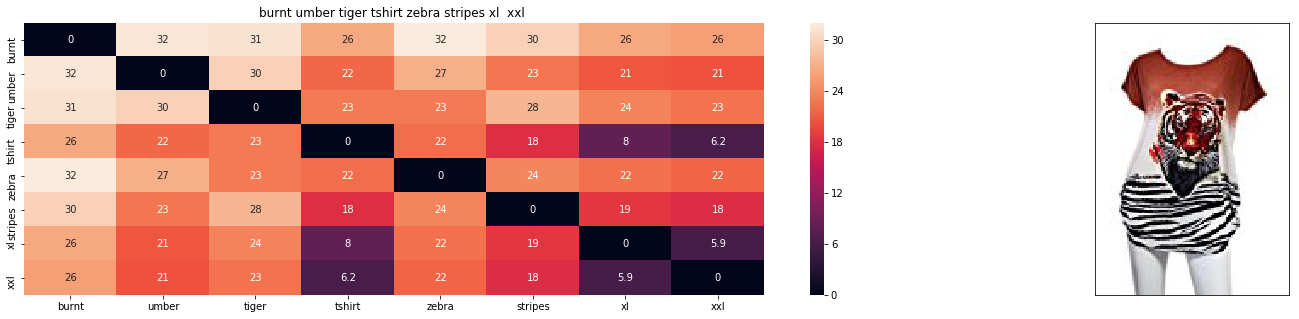

('ASIN :', u'B00JXQB5FQ')
('Brand :', u'Si Row')
('euclidean distance from input :', 0.0)


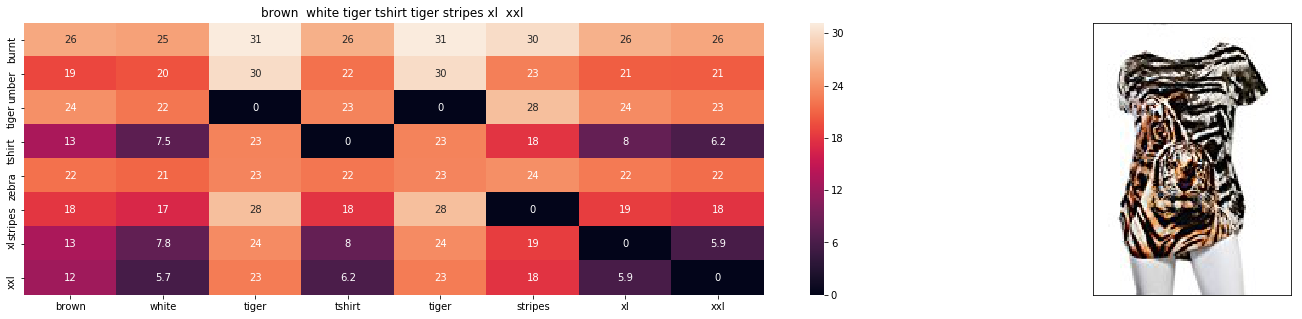

('ASIN :', u'B00JXQCWTO')
('Brand :', u'Si Row')
('euclidean distance from input :', 2.3863937377929689)


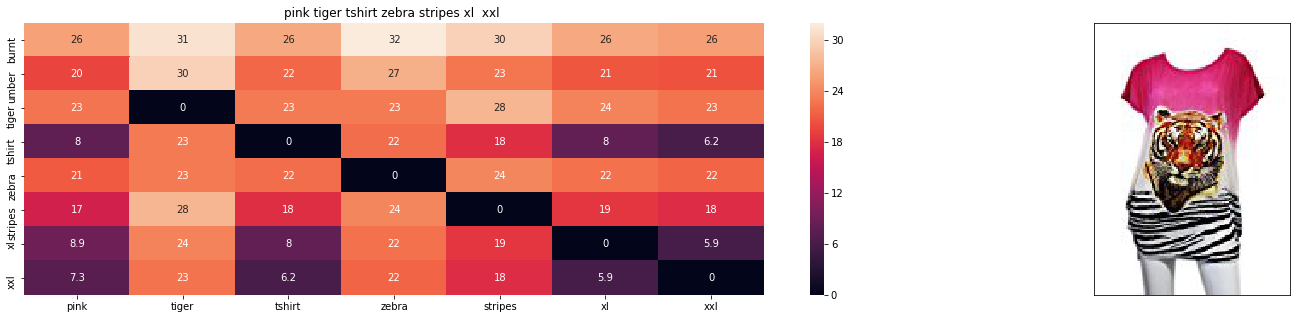

('ASIN :', u'B00JXQASS6')
('Brand :', u'Si Row')
('euclidean distance from input :', 2.7389232637304928)


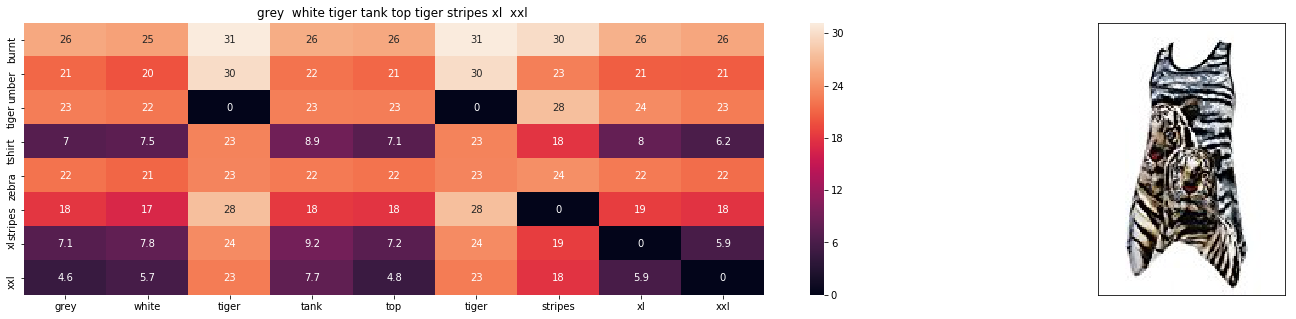

('ASIN :', u'B00JXQAFZ2')
('Brand :', u'Si Row')
('euclidean distance from input :', 3.3903553010840084)


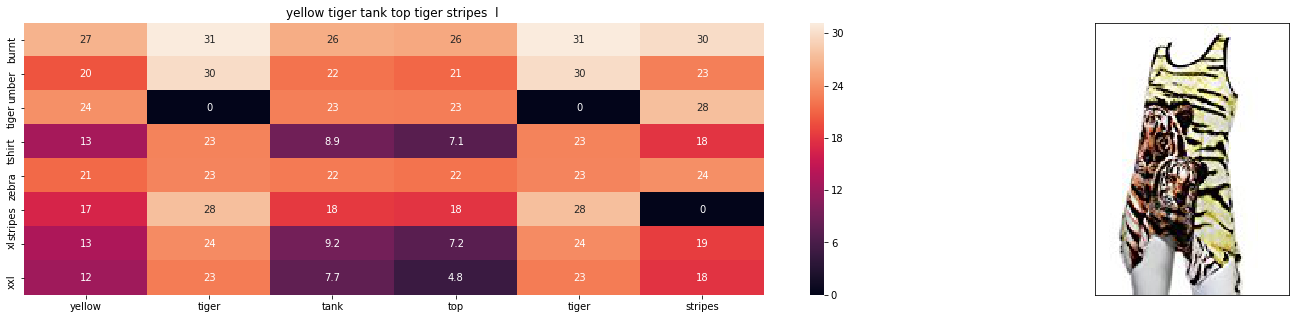

('ASIN :', u'B00JXQAUWA')
('Brand :', u'Si Row')
('euclidean distance from input :', 3.543888282956567)


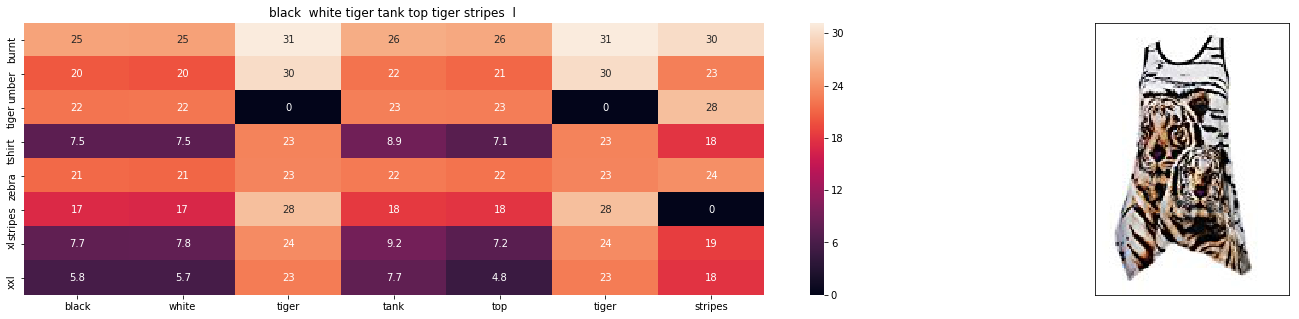

('ASIN :', u'B00JXQAO94')
('Brand :', u'Si Row')
('euclidean distance from input :', 3.5519504548926024)


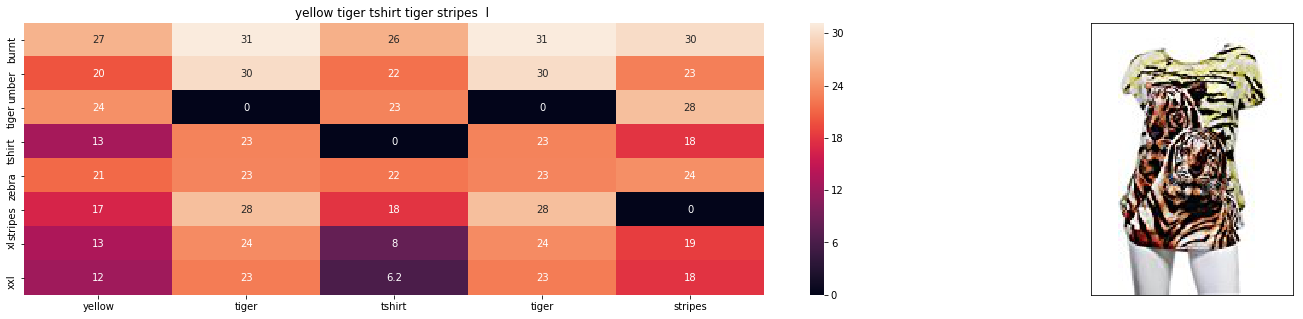

('ASIN :', u'B00JXQCUIC')
('Brand :', u'Si Row')
('euclidean distance from input :', 3.6512636186499265)


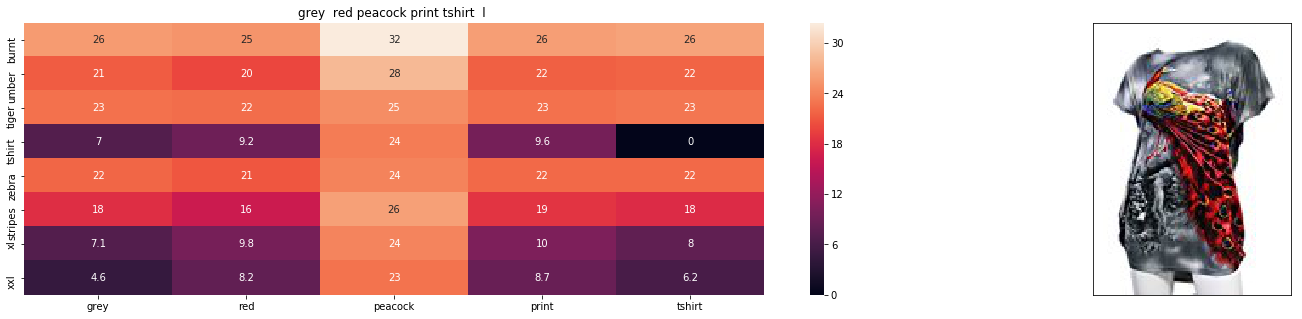

('ASIN :', u'B00JXQCFRS')
('Brand :', u'Si Row')
('euclidean distance from input :', 4.1283802034277581)


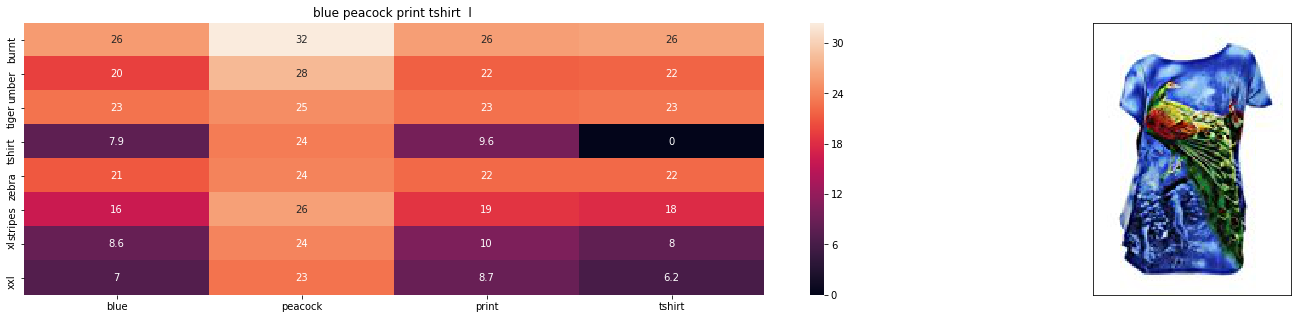

('ASIN :', u'B00JXQC8L6')
('Brand :', u'Si Row')
('euclidean distance from input :', 4.2021072389502194)


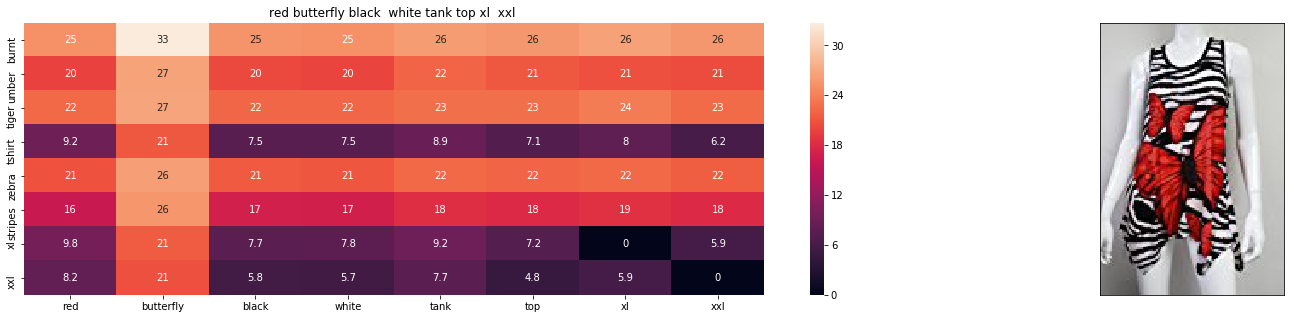

('ASIN :', u'B00JV63CW2')
('Brand :', u'Si Row')
('euclidean distance from input :', 4.2924392702002194)


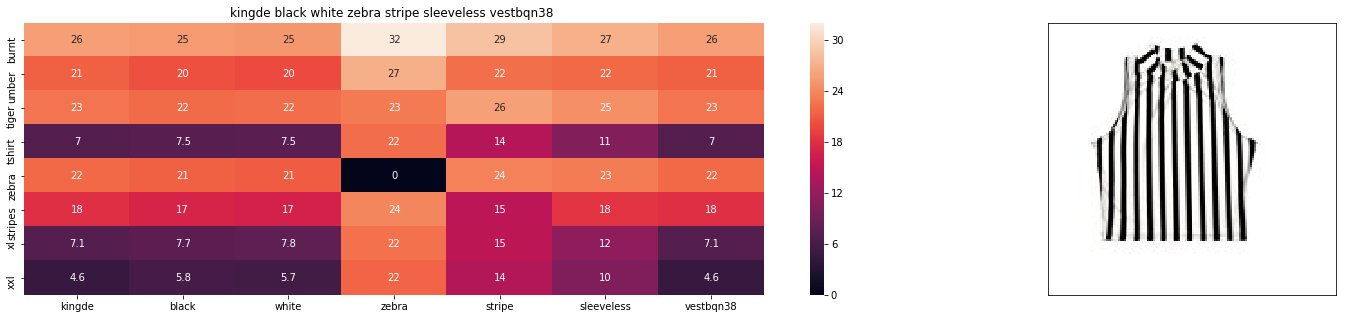

('ASIN :', u'B015H41F6G')
('Brand :', u'KINGDE')
('euclidean distance from input :', 4.3908432611231154)


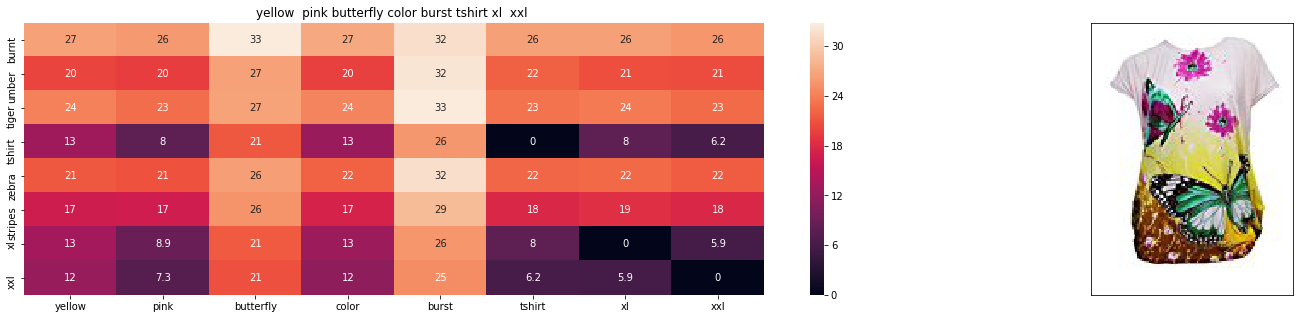

('ASIN :', u'B00JXQBBMI')
('Brand :', u'Si Row')
('euclidean distance from input :', 4.3976169587988521)


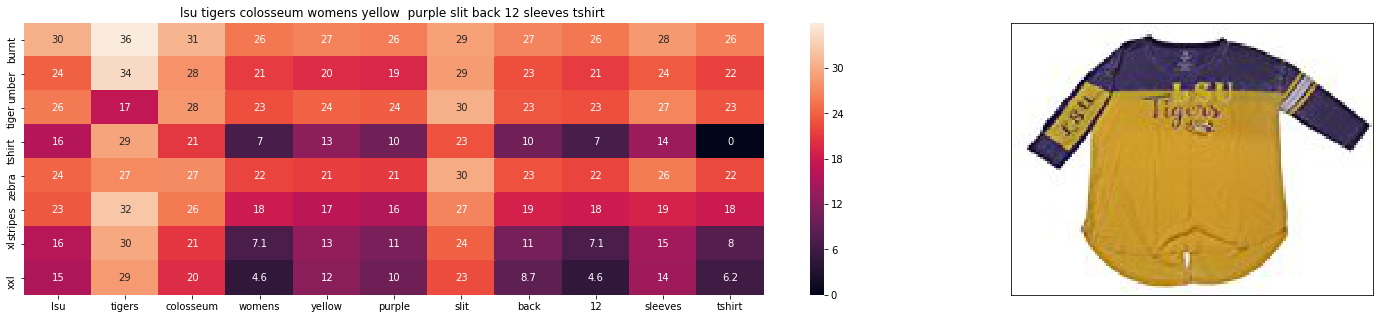

('ASIN :', u'B073R5Q8HD')
('Brand :', u'Colosseum')
('euclidean distance from input :', 4.4491289743189162)


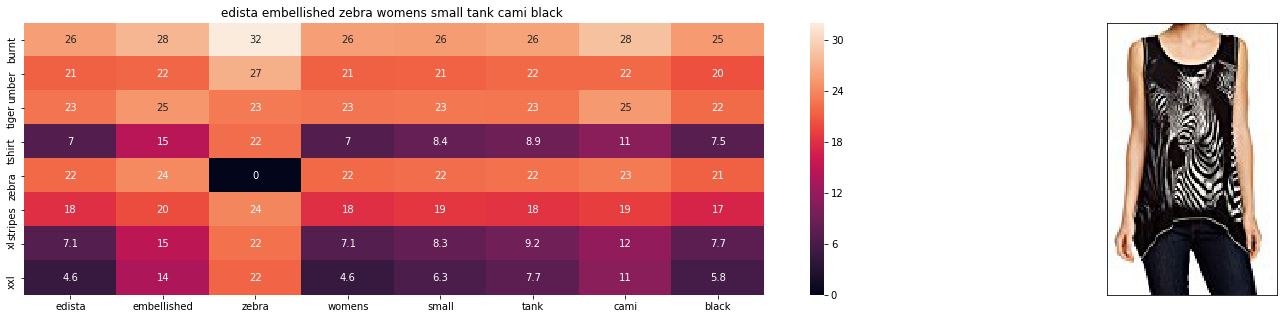

('ASIN :', u'B074P8MD22')
('Brand :', u'Edista')
('euclidean distance from input :', 4.5247711786035847)


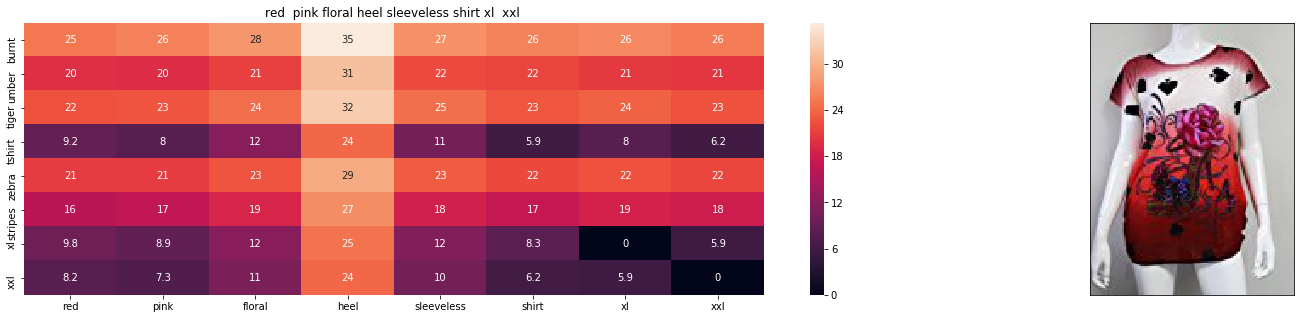

('ASIN :', u'B00JV63QQE')
('Brand :', u'Si Row')
('euclidean distance from input :', 4.5284961702246331)


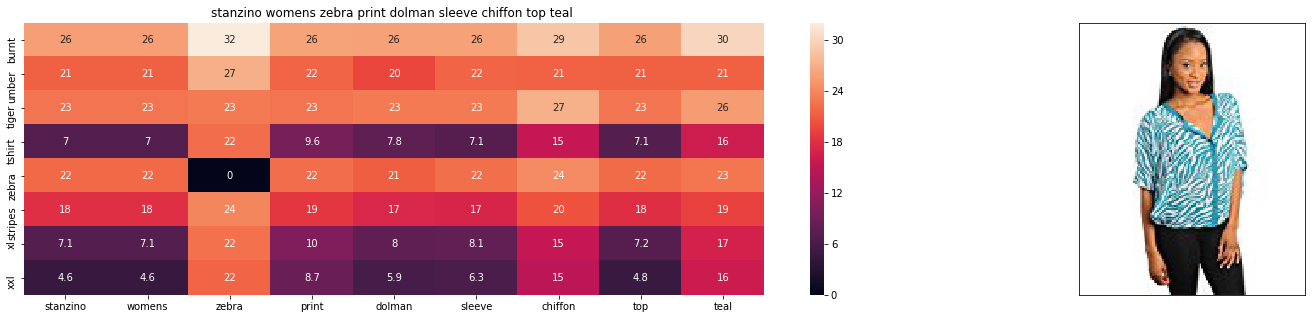

('ASIN :', u'B00C0I3U3E')
('Brand :', u'Stanzino')
('euclidean distance from input :', 4.5357586511377637)


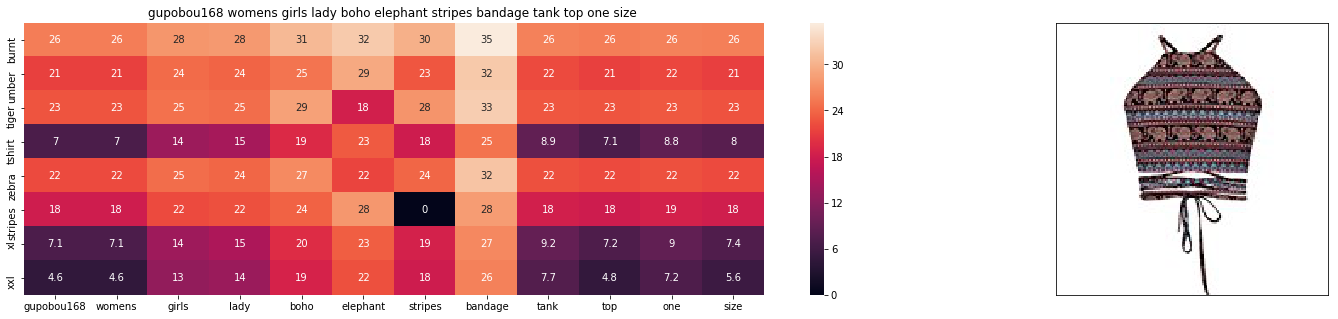

('ASIN :', u'B01ER184O6')
('Brand :', u'GuPoBoU168')
('euclidean distance from input :', 4.5424488141893473)


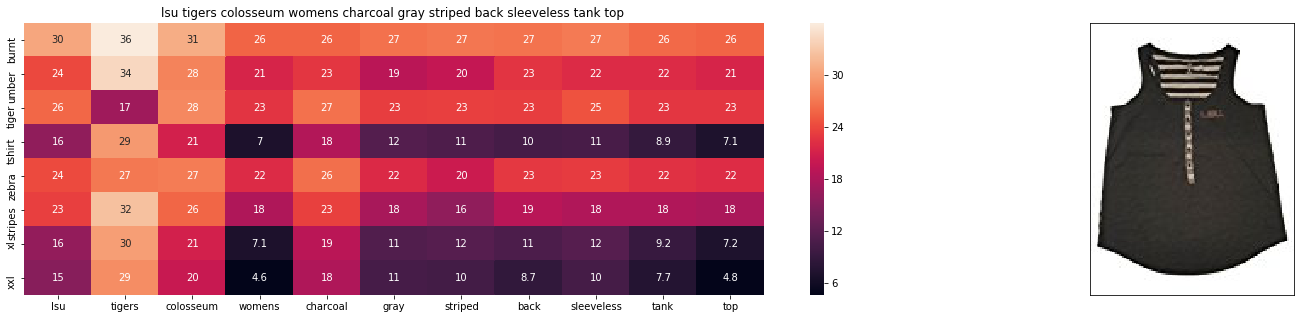

('ASIN :', u'B073R4ZM7Y')
('Brand :', u'Colosseum')
('euclidean distance from input :', 4.5427170404199906)


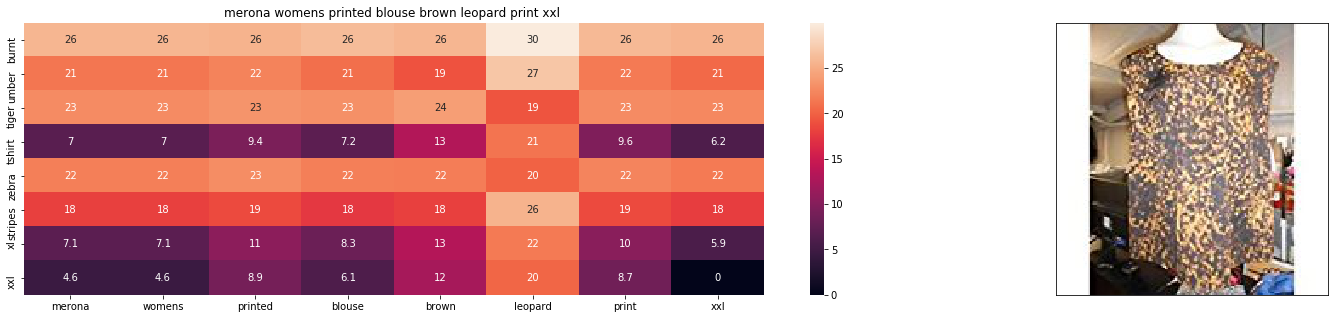

('ASIN :', u'B071YF3WDD')
('Brand :', u'Merona')
('euclidean distance from input :', 4.6108452447656934)


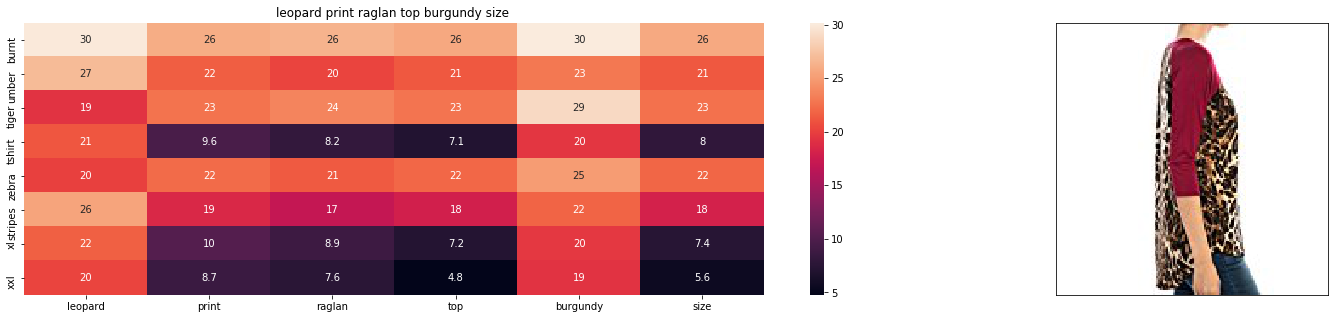

('ASIN :', u'B01C6ORLDQ')
('Brand :', u'1 Mad Fit')
('euclidean distance from input :', 4.6423156741895015)


In [55]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

In [56]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using TensorFlow backend.


In [57]:
#Visual features based product similarity.

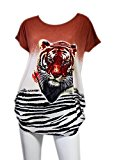

('Product Title: ', u'burnt umber tiger tshirt zebra stripes xl  xxl ')
('Euclidean Distance from input image:', 0.044194173)
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


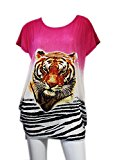

('Product Title: ', u'pink tiger tshirt zebra stripes xl  xxl ')
('Euclidean Distance from input image:', 30.050056)
Amazon Url: www.amzon.com/dp/B00JXQASS6


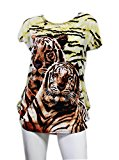

('Product Title: ', u'yellow tiger tshirt tiger stripes  l ')
('Euclidean Distance from input image:', 41.261112)
Amazon Url: www.amzon.com/dp/B00JXQCUIC


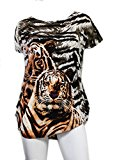

('Product Title: ', u'brown  white tiger tshirt tiger stripes xl  xxl ')
('Euclidean Distance from input image:', 44.00021)
Amazon Url: www.amzon.com/dp/B00JXQCWTO


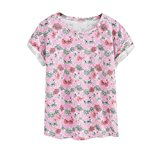

('Product Title: ', u'kawaii pastel tops tees pink flower design ')
('Euclidean Distance from input image:', 47.382504)
Amazon Url: www.amzon.com/dp/B071FCWD97


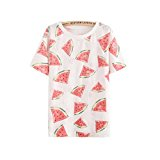

('Product Title: ', u'womens thin style tops tees pastel watermelon print ')
('Euclidean Distance from input image:', 47.71841)
Amazon Url: www.amzon.com/dp/B01JUNHBRM


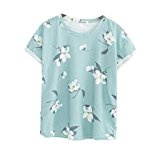

('Product Title: ', u'kawaii pastel tops tees baby blue flower design ')
('Euclidean Distance from input image:', 47.902142)
Amazon Url: www.amzon.com/dp/B071SBCY9W


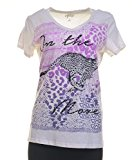

('Product Title: ', u'edv cheetah run purple multi xl ')
('Euclidean Distance from input image:', 48.046497)
Amazon Url: www.amzon.com/dp/B01CUPYBM0


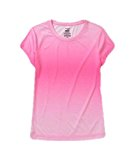

('Product Title: ', u'danskin womens vneck loose performance tee xsmall pink ombre ')
('Euclidean Distance from input image:', 48.101917)
Amazon Url: www.amzon.com/dp/B01F7PHXY8


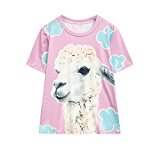

('Product Title: ', u'summer alpaca 3d pastel casual loose tops tee design ')
('Euclidean Distance from input image:', 48.118877)
Amazon Url: www.amzon.com/dp/B01I80A93G


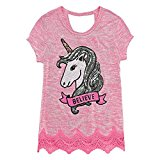

('Product Title: ', u'miss chievous juniors striped peplum tank top medium shadowpeach ')
('Euclidean Distance from input image:', 48.13134)
Amazon Url: www.amzon.com/dp/B0177DM70S


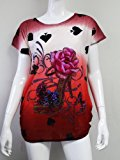

('Product Title: ', u'red  pink floral heel sleeveless shirt xl  xxl ')
('Euclidean Distance from input image:', 48.16946)
Amazon Url: www.amzon.com/dp/B00JV63QQE


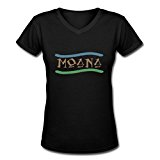

('Product Title: ', u'moana logo adults hot v neck shirt black xxl ')
('Euclidean Distance from input image:', 48.25671)
Amazon Url: www.amzon.com/dp/B01LX6H43D


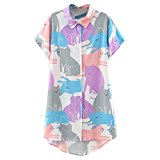

('Product Title: ', u'abaday multicolor cartoon cat print short sleeve longline shirt large ')
('Euclidean Distance from input image:', 48.265621)
Amazon Url: www.amzon.com/dp/B01CR57YY0


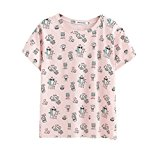

('Product Title: ', u'kawaii cotton pastel tops tees peach pink cactus design ')
('Euclidean Distance from input image:', 48.362682)
Amazon Url: www.amzon.com/dp/B071WYLBZS


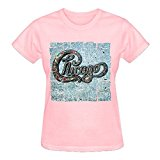

('Product Title: ', u'chicago chicago 18 shirt women pink ')
('Euclidean Distance from input image:', 48.383518)
Amazon Url: www.amzon.com/dp/B01GXAZTRY


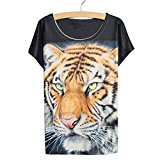

('Product Title: ', u'yichun womens tiger printed summer tshirts tops ')
('Euclidean Distance from input image:', 48.449333)
Amazon Url: www.amzon.com/dp/B010NN9RXO


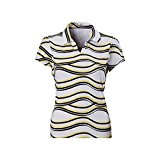

('Product Title: ', u'nancy lopez whimsy short sleeve  whiteblacklemon drop  xs ')
('Euclidean Distance from input image:', 48.478813)
Amazon Url: www.amzon.com/dp/B01MPX6IDX


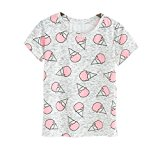

('Product Title: ', u'womens tops tees pastel peach ice cream cone print ')
('Euclidean Distance from input image:', 48.557926)
Amazon Url: www.amzon.com/dp/B0734GRKZL


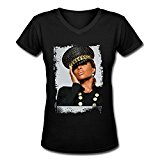

('Product Title: ', u'uswomens mary j blige without tshirts shirt ')
('Euclidean Distance from input image:', 48.614334)
Amazon Url: www.amzon.com/dp/B01M0XXFKK


In [59]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed_py2')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)
